In [1]:

# Clean header
quest_df["field"] = quest_df["field"].str.replace("#", "").str.strip()

print("Questionnaire loaded:")
print(quest_df, "\n")

NameError: name 'quest_df' is not defined

In [ ]:
import pickle
s1=r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1.pkl"
with open(s1, "rb") as f:
    s1=pickle.load(f, encoding="latin1")
print("S1 loaded")
print(type(s1))

S1 loaded
<class 'dict'>


In [ ]:
print("Top-level keys:", s1.keys())


Top-level keys: dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])


In [ ]:
print("Signal keys:", s1["signal"].keys())


Signal keys: dict_keys(['chest', 'wrist'])


In [ ]:
print("Chest keys:", s1["signal"]["chest"].keys())
print("Wrist keys:", s1["signal"]["wrist"].keys())


Chest keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
Wrist keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


In [ ]:
print("Does s1 contain fs? ->", "fs" in s1)


Does s1 contain fs? -> False


In [ ]:
def find_fs(obj):
    if isinstance(obj, dict):
        for k, v in obj.items():
            if "fs" in k.lower():
                print("Found fs key:", k, v)
            find_fs(v)
    if isinstance(obj, list):
        for item in obj:
            find_fs(item)

find_fs(s1)


In [ ]:
print("ECG length:", ecg.shape)


ECG length: (6448400, 1)


In [ ]:
import numpy as np
for k, v in s1.items():
    print(k, type(v))


rpeaks <class 'numpy.ndarray'>
signal <class 'dict'>
label <class 'numpy.ndarray'>
activity <class 'numpy.ndarray'>
questionnaire <class 'dict'>
subject <class 'str'>


In [ ]:
# Extract ECG signal
ecg = s1["signal"]["chest"]["ECG"]
print("ECG length:", len(ecg))
print("First 10 samples:", ecg[:10])


ECG length: 6448400
First 10 samples: [[0.01560974]
 [0.01812744]
 [0.01753235]
 [0.01341248]
 [0.01194763]
 [0.0133667 ]
 [0.01304626]
 [0.01313782]
 [0.02146912]
 [0.03144836]]


In [ ]:
resp = s1["signal"]["chest"]["Resp"]
print("Resp length:", len(resp))


Resp length: 6448400


In [ ]:
bvp = s1["signal"]["wrist"]["BVP"]
print("PPG length:", len(bvp))


PPG length: 589568


In [ ]:
fs_ecg = 700   # ECG sampling rate
fs_bvp = 64    # PPG sampling rate
fs_acc = 32


In [ ]:
ecg = ecg.flatten()


In [ ]:
import pandas as pd
path="G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1_activity.csv"
activity_df = pd.read_csv(path)
activity_df.columns = ["raw_label", "index"]

# Clean labels
activity_df["label"] = (
    activity_df["raw_label"]
    .str.replace("#", "", regex=False)
    .str.strip()
)

activity_df["index"] = activity_df["index"].astype(int)

# Ready/fatigued mapping
READY = {"NO_ACTIVITY", "BASELINE", "CLEAN_BASELINE", "DRIVING", "LUNCH", "WORKING"}
FATIGUE = {"STAIRS", "SOCCER", "CYCLING", "WALKING"}

segments = []

for i in range(len(activity_df) - 1):
    start_idx = activity_df.iloc[i]["index"]
    end_idx   = activity_df.iloc[i+1]["index"]
    act       = activity_df.iloc[i]["label"]
    
    # assign state
    if act in READY:
        state = "ready"
    elif act in FATIGUE:
        state = "fatigued"
    else:
        state = "unknown"

    segments.append({
        "start_idx": start_idx,
        "end_idx": end_idx,
        "activity": act,
        "state": state,
        "duration_sec": (end_idx - start_idx) / 700  # using fs=700
    })

segments_df = pd.DataFrame(segments)
segments_df


,start_idx,end_idx,activity,state,duration_sec
0,0,90,NO_ACTIVITY,ready,0.128571
1,90,791,BASELINE,ready,1.001429
2,791,837,NO_ACTIVITY,ready,0.065714
3,837,1125,STAIRS,fatigued,0.411429
4,1125,1210,NO_ACTIVITY,ready,0.121429
5,1210,1556,SOCCER,fatigued,0.494286
6,1556,1918,NO_ACTIVITY,ready,0.517143
7,1918,2331,CYCLING,fatigued,0.590000
8,2331,2935,NO_ACTIVITY,ready,0.862857
9,2935,3825,DRIVING,ready,1.271429


In [ ]:
ecg = s1["signal"]["chest"]["ECG"].flatten()


In [ ]:
import neurokit2 as nk
import numpy as np

def compute_segment_features(ecg_seg, fs):
    """Compute HRV features and simple quality metrics for one ECG segment."""
    # Clean ECG
    ecg_clean = nk.ecg_clean(ecg_seg, sampling_rate=fs)

    # Detect R-peaks
    _, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r_locs = rpeaks["ECG_R_Peaks"]
    n_beats = len(r_locs)

    duration_sec = len(ecg_seg) / fs
    if duration_sec == 0 or n_beats < 2:
        return None  # unusable

    # Rough heart rate estimate
    hr = n_beats * 60.0 / duration_sec

    # Time-domain HRV
    hrv_time = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)
    # Frequency-domain HRV
    hrv_freq = nk.hrv_frequency(rpeaks, sampling_rate=fs, show=False)

    features = {}
    features.update(hrv_time.iloc[0].to_dict())
    features.update(hrv_freq.iloc[0].to_dict())
    features["HR_est"] = hr
    features["n_beats"] = n_beats
    features["segment_duration"] = duration_sec

    # --- Simple SQI (Signal Quality Index) ---
    # 1) Heart rate sanity check
    if hr < 35 or hr > 200:
        sqi_hr = 0.0
    else:
        sqi_hr = 1.0

    # 2) Beat density sanity check (beats per minute vs duration)
    expected_min_beats = 0.5 * duration_sec / 60.0 * 60  # ~30 bpm baseline
    sqi_beats = min(1.0, n_beats / max(1.0, expected_min_beats))

    # Final SQI: simple average
    features["SQI"] = float(0.5 * sqi_hr + 0.5 * sqi_beats)

    return features


In [ ]:
feature_rows = []

min_seg_duration = 60  # only use â‰¥60-second segments for HRV

for _, row in segments_df.iterrows():
    if row["state"] == "unknown":
        continue
    if row["duration_sec"] < min_seg_duration:
        continue  # too short for meaningful HRV

    seg_ecg = ecg[row["start_idx"]:row["end_idx"]]

    try:
        feats = compute_segment_features(seg_ecg, fs_ecg)
        if feats is None:
            continue
    except Exception as e:
        print(f"Skipping segment {row['activity']} ({row['start_time_sec']}â€“{row['end_time_sec']}s):", e)
        continue

    feats["activity"] = row["activity"]
    feats["state"] = row["state"]
    feats["start_time_sec"] = row["start_time_sec"]
    feats["end_time_sec"] = row["end_time_sec"]
    feats["duration_sec"] = row["duration_sec"]

    feature_rows.append(feats)

features_df = pd.DataFrame(feature_rows)
print(features_df.head())
print("Segments with features:", len(features_df))


Empty DataFrame
Columns: []
Index: []
Segments with features: 0


In [ ]:
print(features_df.columns)


RangeIndex(start=0, stop=0, step=1)


In [ ]:
print("Total segments in segments_df:", len(segments_df))
print("Segments >= 60 sec:", sum(segments_df['duration_sec'] >= 60))
print("Segments with known state:", sum(segments_df['state'] != 'unknown'))


Total segments in segments_df: 17
Segments >= 60 sec: 0
Segments with known state: 17


In [ ]:
window_size = 60 * fs_ecg         # 42000 samples
step_size   = 30 * fs_ecg         # overlap = 30 sec


In [2]:
import pickle
import numpy as np
import pandas as pd

# Your paths
s1_path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1.pkl"
act_path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1_activity.csv"

with open(s1_path, "rb") as f:
    s1 = pickle.load(f, encoding="latin1")

ecg = s1["signal"]["chest"]["ECG"].flatten()   # (6448400,)
fs_ecg = 700                                   # Hz, from dataset docs


In [3]:
# Load activity file
activity_df = pd.read_csv(act_path)
activity_df.columns = ["raw_label", "time_sec"]

# Clean text labels
activity_df["activity"] = (
    activity_df["raw_label"]
    .str.replace("#", "", regex=False)
    .str.strip()
)

activity_df["time_sec"] = activity_df["time_sec"].astype(float)

# Make sure it's sorted by time
activity_df = activity_df.sort_values("time_sec").reset_index(drop=True)

activity_df


,raw_label,time_sec,activity
0,# NO_ACTIVITY,0.0,NO_ACTIVITY
1,# BASELINE,90.0,BASELINE
2,# NO_ACTIVITY,791.0,NO_ACTIVITY
3,# STAIRS,837.0,STAIRS
4,# NO_ACTIVITY,1125.0,NO_ACTIVITY
5,# SOCCER,1210.0,SOCCER
6,# NO_ACTIVITY,1556.0,NO_ACTIVITY
7,# CYCLING,1918.0,CYCLING
8,# NO_ACTIVITY,2331.0,NO_ACTIVITY
9,# DRIVING,2935.0,DRIVING


In [4]:
READY = {"NO_ACTIVITY", "BASELINE", "CLEAN_BASELINE", "DRIVING", "LUNCH", "WORKING"}
FATIGUE = {"STAIRS", "SOCCER", "CYCLING", "WALKING"}

def activity_to_state(activity: str) -> str:
    if activity in READY:
        return "ready"
    if activity in FATIGUE:
        return "fatigued"
    return "unknown"


In [5]:
def get_activity_at_time(t_sec: float, activity_df: pd.DataFrame) -> str:
    """
    Returns the activity label active at time t_sec.
    We take the last activity whose time_sec <= t_sec.
    """
    # all events that happened up to this time
    candidates = activity_df[activity_df["time_sec"] <= t_sec]
    if candidates.empty:
        return "unknown"
    return candidates.iloc[-1]["activity"]


In [6]:
for t in [0, 100, 900, 2000, 5000, 8000]:
    act = get_activity_at_time(t, activity_df)
    print(f"t = {t:5.0f} s â†’ activity = {act}, state = {activity_to_state(act)}")


t =     0 s â†’ activity = NO_ACTIVITY, state = ready
t =   100 s â†’ activity = BASELINE, state = ready
t =   900 s â†’ activity = STAIRS, state = fatigued
t =  2000 s â†’ activity = CYCLING, state = fatigued
t =  5000 s â†’ activity = LUNCH, state = ready
t =  8000 s â†’ activity = WORKING, state = ready


In [7]:
import neurokit2 as nk

def compute_window_features(ecg_seg: np.ndarray, fs: int):
    """
    Compute HRV + simple SQI for one ECG window.
    Returns a dict or None if unusable.
    """
    # Clean ECG
    ecg_clean = nk.ecg_clean(ecg_seg, sampling_rate=fs)

    # Detect R-peaks
    _, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r_locs = rpeaks["ECG_R_Peaks"]
    n_beats = len(r_locs)

    duration_sec = len(ecg_seg) / fs
    if duration_sec < 30 or n_beats < 3:
        return None  # too short / too few beats

    # Basic HR estimate
    hr = n_beats * 60.0 / duration_sec

    # Time-domain HRV
    hrv_time = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)
    # Frequency-domain HRV
    hrv_freq = nk.hrv_frequency(rpeaks, sampling_rate=fs, show=False)

    feats = {}
    feats.update(hrv_time.iloc[0].to_dict())
    feats.update(hrv_freq.iloc[0].to_dict())
    feats["HR_est"] = hr
    feats["n_beats"] = n_beats
    feats["window_duration_sec"] = duration_sec

    # ---- Simple SQI ----
    # 1) HR plausibility
    if hr < 35 or hr > 200:
        sqi_hr = 0.0
    else:
        sqi_hr = 1.0

    # 2) Beat density (roughly: enough beats for duration)
    min_expected_hr = 35  # bpm
    min_expected_beats = min_expected_hr * duration_sec / 60.0
    sqi_beats = min(1.0, n_beats / max(1.0, min_expected_beats))

    feats["SQI"] = float(0.5 * sqi_hr + 0.5 * sqi_beats)

    return feats


In [8]:
window_sec = 90
step_sec   = 15

window_samples = int(window_sec * fs_ecg)
step_samples   = int(step_sec * fs_ecg)

total_sec = len(ecg) / fs_ecg
print("Total ECG duration ~", total_sec / 60, "minutes")

feature_rows = []

start_sample = 0
while start_sample + window_samples <= len(ecg):
    end_sample = start_sample + window_samples

    # time (in seconds) at middle of window
    center_sample = (start_sample + end_sample) / 2.0
    center_time_sec = center_sample / fs_ecg

    activity = get_activity_at_time(center_time_sec, activity_df)
    state = activity_to_state(activity)

    if state == "unknown":
        # move on, but still slide
        start_sample += step_samples
        continue

    ecg_seg = ecg[start_sample:end_sample]

    try:
        feats = compute_window_features(ecg_seg, fs_ecg)
    except Exception as e:
        print(f"Skipping window at {center_time_sec:.1f}s due to error:", e)
        start_sample += step_samples
        continue

    if feats is None:
        start_sample += step_samples
        continue

    # Add metadata
    feats["activity"] = activity
    feats["state"] = state
    feats["start_time_sec"] = start_sample / fs_ecg
    feats["end_time_sec"] = end_sample / fs_ecg
    feats["center_time_sec"] = center_time_sec

    feature_rows.append(feats)

    # Slide
    start_sample += step_samples

features_df = pd.DataFrame(feature_rows)
print("Windows with features:", len(features_df))
features_df.head()


Total ECG duration ~ 153.53333333333333 minutes
Windows with features: 609


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_LnHF,HR_est,n_beats,window_duration_sec,SQI,activity,state,start_time_sec,end_time_sec,center_time_sec
0,1018.193760,164.447481,NaN,NaN,NaN,NaN,NaN,NaN,140.944169,141.711230,...,-4.735823,58.666667,88,90.0,1.0,NO_ACTIVITY,ready,0.0,90.0,45.0
1,1049.058824,167.226933,NaN,NaN,NaN,NaN,NaN,NaN,114.533426,115.120978,...,-4.549986,57.333333,86,90.0,1.0,NO_ACTIVITY,ready,15.0,105.0,60.0
2,1113.688969,176.308980,NaN,NaN,NaN,NaN,NaN,NaN,141.577603,142.332412,...,-5.422623,53.333333,80,90.0,1.0,NO_ACTIVITY,ready,30.0,120.0,75.0
3,1167.312030,197.108067,NaN,NaN,NaN,NaN,NaN,NaN,144.628447,145.469770,...,-4.782728,51.333333,77,90.0,1.0,BASELINE,ready,45.0,135.0,90.0
4,1217.064579,211.552394,NaN,NaN,NaN,NaN,NaN,NaN,145.205890,146.133997,...,-4.513836,49.333333,74,90.0,1.0,BASELINE,ready,60.0,150.0,105.0


In [9]:
print(features_df.columns)  # just to confirm

# Keep only reasonably good windows
clean_df = features_df[features_df["SQI"] >= 0.75].reset_index(drop=True)
print("Clean windows:", len(clean_df))
clean_df[["activity", "state", "SQI"]].head()


Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF',
       'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats',
       'window_duration_sec', 'SQI', 'activity', 'state', 'start_time_sec',
       'end_time_sec', 'center_time_sec'],
      dtype='object')
Clean windows: 609


,activity,state,SQI
0,NO_ACTIVITY,ready,1.0
1,NO_ACTIVITY,ready,1.0
2,NO_ACTIVITY,ready,1.0
3,BASELINE,ready,1.0
4,BASELINE,ready,1.0


In [10]:
# Columns to exclude from PCA/GMM
exclude_cols = ["activity", "state", "start_time_sec", "end_time_sec", "center_time_sec"]

num_cols = [c for c in clean_df.columns 
            if c not in exclude_cols and clean_df[c].dtype != "object"]

print("Numeric feature columns:", num_cols)


Numeric feature columns: ['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats', 'window_duration_sec', 'SQI']


In [13]:
print("Total HRV windows in features_df:", len(features_df))
print("Columns in features_df:", features_df.columns)


Total HRV windows in features_df: 609
Columns in features_df: Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF',
       'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats',
       'window_duration_sec', 'SQI', 'activity', 'state', 'start_time_sec',
       'end_time_sec', 'center_time_sec'],
      dtype='object')


In [14]:
print("Clean windows:", len(clean_df))
clean_df.head()


Clean windows: 609


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_LnHF,HR_est,n_beats,window_duration_sec,SQI,activity,state,start_time_sec,end_time_sec,center_time_sec
0,1018.193760,164.447481,NaN,NaN,NaN,NaN,NaN,NaN,140.944169,141.711230,...,-4.735823,58.666667,88,90.0,1.0,NO_ACTIVITY,ready,0.0,90.0,45.0
1,1049.058824,167.226933,NaN,NaN,NaN,NaN,NaN,NaN,114.533426,115.120978,...,-4.549986,57.333333,86,90.0,1.0,NO_ACTIVITY,ready,15.0,105.0,60.0
2,1113.688969,176.308980,NaN,NaN,NaN,NaN,NaN,NaN,141.577603,142.332412,...,-5.422623,53.333333,80,90.0,1.0,NO_ACTIVITY,ready,30.0,120.0,75.0
3,1167.312030,197.108067,NaN,NaN,NaN,NaN,NaN,NaN,144.628447,145.469770,...,-4.782728,51.333333,77,90.0,1.0,BASELINE,ready,45.0,135.0,90.0
4,1217.064579,211.552394,NaN,NaN,NaN,NaN,NaN,NaN,145.205890,146.133997,...,-4.513836,49.333333,74,90.0,1.0,BASELINE,ready,60.0,150.0,105.0


In [15]:
print("Raw HRV windows:", len(features_df))
print(features_df[["HR_est", "n_beats", "SQI"]].head())


Raw HRV windows: 609
      HR_est  n_beats  SQI
0  58.666667       88  1.0
1  57.333333       86  1.0
2  53.333333       80  1.0
3  51.333333       77  1.0
4  49.333333       74  1.0


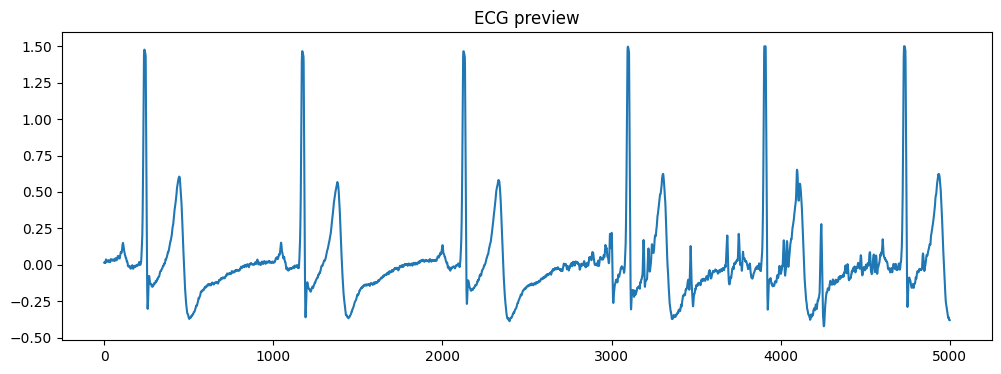

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(ecg[:5000])
plt.title("ECG preview")
plt.show()


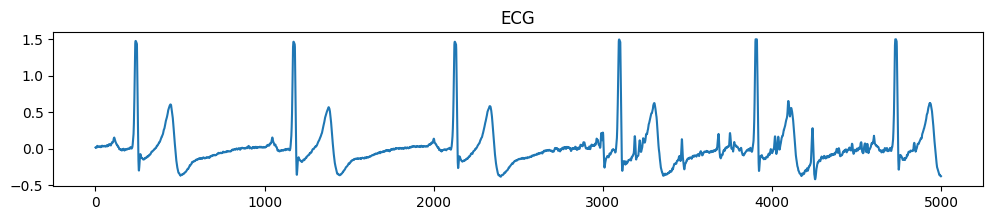

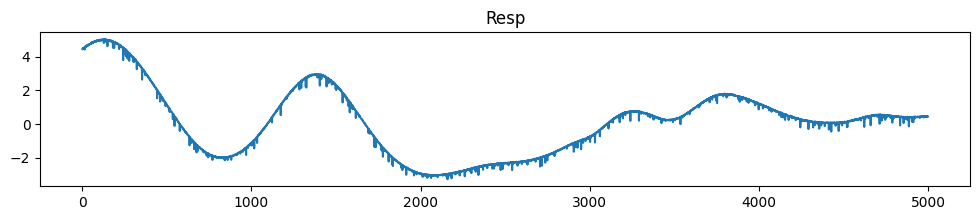

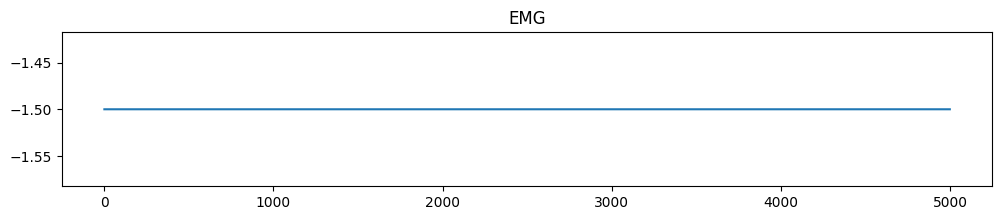

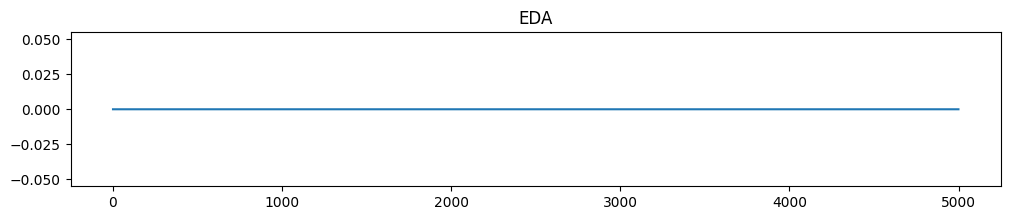

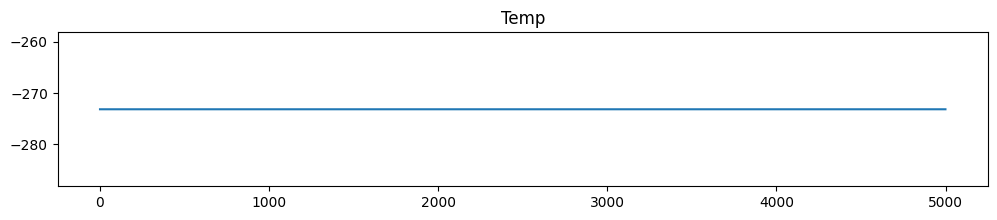

In [17]:
for ch in ["ECG", "Resp", "EMG", "EDA", "Temp"]:
    sig = s1["signal"]["chest"][ch].flatten()
    plt.figure(figsize=(12,2))
    plt.plot(sig[:5000])
    plt.title(ch)
    plt.show()


In [18]:
test_seg = ecg[0 : 90*fs_ecg]   # first 90 seconds
feats = compute_window_features(test_seg, fs_ecg)
print(feats)


{'HRV_MeanNN': 1018.1937602627256, 'HRV_SDNN': 164.4474806302146, 'HRV_SDANN1': nan, 'HRV_SDNNI1': nan, 'HRV_SDANN2': nan, 'HRV_SDNNI2': nan, 'HRV_SDANN5': nan, 'HRV_SDNNI5': nan, 'HRV_RMSSD': 140.94416859737115, 'HRV_SDSD': 141.71122977029978, 'HRV_CVNN': 0.16150902416430254, 'HRV_CVSD': 0.13842568487259554, 'HRV_MedianNN': 1014.2857142857142, 'HRV_MadNN': 182.14800000000037, 'HRV_MCVNN': 0.179582535211268, 'HRV_IQRNN': 242.14285714285734, 'HRV_SDRMSSD': 1.166756186273902, 'HRV_Prc20NN': 865.7142857142858, 'HRV_Prc80NN': 1166.857142857143, 'HRV_pNN50': 60.91954022988506, 'HRV_pNN20': 86.20689655172413, 'HRV_MinNN': 474.28571428571433, 'HRV_MaxNN': 1397.1428571428573, 'HRV_HTI': 17.4, 'HRV_TINN': 593.75, 'HRV_ULF': nan, 'HRV_VLF': nan, 'HRV_LF': 0.02946634332148832, 'HRV_HF': 0.008775219903791313, 'HRV_VHF': 0.0005414585817771288, 'HRV_TP': 0.03878302180705676, 'HRV_LFHF': 3.357903692961296, 'HRV_LFn': 0.7597743019634116, 'HRV_HFn': 0.22626447076371492, 'HRV_LnHF': -4.735823449683092, 

In [19]:
feats = compute_window_features(test_seg, fs_ecg)
print(feats)


{'HRV_MeanNN': 1018.1937602627256, 'HRV_SDNN': 164.4474806302146, 'HRV_SDANN1': nan, 'HRV_SDNNI1': nan, 'HRV_SDANN2': nan, 'HRV_SDNNI2': nan, 'HRV_SDANN5': nan, 'HRV_SDNNI5': nan, 'HRV_RMSSD': 140.94416859737115, 'HRV_SDSD': 141.71122977029978, 'HRV_CVNN': 0.16150902416430254, 'HRV_CVSD': 0.13842568487259554, 'HRV_MedianNN': 1014.2857142857142, 'HRV_MadNN': 182.14800000000037, 'HRV_MCVNN': 0.179582535211268, 'HRV_IQRNN': 242.14285714285734, 'HRV_SDRMSSD': 1.166756186273902, 'HRV_Prc20NN': 865.7142857142858, 'HRV_Prc80NN': 1166.857142857143, 'HRV_pNN50': 60.91954022988506, 'HRV_pNN20': 86.20689655172413, 'HRV_MinNN': 474.28571428571433, 'HRV_MaxNN': 1397.1428571428573, 'HRV_HTI': 17.4, 'HRV_TINN': 593.75, 'HRV_ULF': nan, 'HRV_VLF': nan, 'HRV_LF': 0.02946634332148832, 'HRV_HF': 0.008775219903791313, 'HRV_VHF': 0.0005414585817771288, 'HRV_TP': 0.03878302180705676, 'HRV_LFHF': 3.357903692961296, 'HRV_LFn': 0.7597743019634116, 'HRV_HFn': 0.22626447076371492, 'HRV_LnHF': -4.735823449683092, 

In [21]:
clean_df = features_df[features_df["SQI"] >= 0.75].reset_index(drop=True)
print("Clean windows:", len(clean_df))


Clean windows: 609


In [22]:
exclude_cols = ["activity", "state", 
                "start_time_sec", "end_time_sec", 
                "center_time_sec"]

num_cols = [c for c in clean_df.columns if c not in exclude_cols and clean_df[c].dtype != "object"]


In [24]:
# Prepare X without scaling
X = clean_df[num_cols].replace([np.inf, -np.inf], np.nan).dropna()
y_state = clean_df.loc[X.index, "state"]

# Use raw HRV features instead of standardized values
X_scaled = X.values   # NO SCALING

print("Final input windows:", X_scaled.shape)


Final input windows: (0, 39)


In [27]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
gmm.fit(X)

clean_df.loc[X.index, "cluster"] = gmm.predict(X_pca)


ValueError: Found array with 0 sample(s) (shape=(0, 39)) while a minimum of 2 is required by GaussianMixture.

In [28]:
print("features_df rows:", len(features_df))
print(features_df.head())


features_df rows: 609
    HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1018.193760  164.447481         NaN         NaN         NaN         NaN   
1  1049.058824  167.226933         NaN         NaN         NaN         NaN   
2  1113.688969  176.308980         NaN         NaN         NaN         NaN   
3  1167.312030  197.108067         NaN         NaN         NaN         NaN   
4  1217.064579  211.552394         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_LnHF     HR_est  \
0         NaN         NaN  140.944169  141.711230  ... -4.735823  58.666667   
1         NaN         NaN  114.533426  115.120978  ... -4.549986  57.333333   
2         NaN         NaN  141.577603  142.332412  ... -5.422623  53.333333   
3         NaN         NaN  144.628447  145.469770  ... -4.782728  51.333333   
4         NaN         NaN  145.205890  146.133997  ... -4.513836  49.333333   

   n_beats  window_duration_sec  S

In [29]:
print("clean_df rows:", len(clean_df))
print(clean_df.head())


clean_df rows: 609
    HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1018.193760  164.447481         NaN         NaN         NaN         NaN   
1  1049.058824  167.226933         NaN         NaN         NaN         NaN   
2  1113.688969  176.308980         NaN         NaN         NaN         NaN   
3  1167.312030  197.108067         NaN         NaN         NaN         NaN   
4  1217.064579  211.552394         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_LnHF     HR_est  \
0         NaN         NaN  140.944169  141.711230  ... -4.735823  58.666667   
1         NaN         NaN  114.533426  115.120978  ... -4.549986  57.333333   
2         NaN         NaN  141.577603  142.332412  ... -5.422623  53.333333   
3         NaN         NaN  144.628447  145.469770  ... -4.782728  51.333333   
4         NaN         NaN  145.205890  146.133997  ... -4.513836  49.333333   

   n_beats  window_duration_sec  SQI 

In [30]:
# --- REBUILD features_df completely from scratch ---

feature_rows = []

start_sample = 0
while start_sample + window_samples <= len(ecg):
    end_sample = start_sample + window_samples

    center_sample = (start_sample + end_sample) / 2.0
    center_time_sec = center_sample / fs_ecg

    activity = get_activity_at_time(center_time_sec, activity_df)
    state = activity_to_state(activity)

    if state == "unknown":
        start_sample += step_samples
        continue

    ecg_seg = ecg[start_sample:end_sample]

    feats = compute_window_features(ecg_seg, fs_ecg)
    if feats is None:
        start_sample += step_samples
        continue

    feats["activity"] = activity
    feats["state"] = state
    feats["start_time_sec"] = start_sample / fs_ecg
    feats["end_time_sec"] = end_sample / fs_ecg
    feats["center_time_sec"] = center_time_sec

    feature_rows.append(feats)
    start_sample += step_samples

features_df = pd.DataFrame(feature_rows)
print("Recomputed features_df rows:", len(features_df))
features_df.head()


Recomputed features_df rows: 609


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_LnHF,HR_est,n_beats,window_duration_sec,SQI,activity,state,start_time_sec,end_time_sec,center_time_sec
0,1018.193760,164.447481,NaN,NaN,NaN,NaN,NaN,NaN,140.944169,141.711230,...,-4.735823,58.666667,88,90.0,1.0,NO_ACTIVITY,ready,0.0,90.0,45.0
1,1049.058824,167.226933,NaN,NaN,NaN,NaN,NaN,NaN,114.533426,115.120978,...,-4.549986,57.333333,86,90.0,1.0,NO_ACTIVITY,ready,15.0,105.0,60.0
2,1113.688969,176.308980,NaN,NaN,NaN,NaN,NaN,NaN,141.577603,142.332412,...,-5.422623,53.333333,80,90.0,1.0,NO_ACTIVITY,ready,30.0,120.0,75.0
3,1167.312030,197.108067,NaN,NaN,NaN,NaN,NaN,NaN,144.628447,145.469770,...,-4.782728,51.333333,77,90.0,1.0,BASELINE,ready,45.0,135.0,90.0
4,1217.064579,211.552394,NaN,NaN,NaN,NaN,NaN,NaN,145.205890,146.133997,...,-4.513836,49.333333,74,90.0,1.0,BASELINE,ready,60.0,150.0,105.0


In [31]:
clean_df = features_df[features_df["SQI"] >= 0.75].reset_index(drop=True)
print("clean_df rows:", len(clean_df))
clean_df.head()


clean_df rows: 609


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_LnHF,HR_est,n_beats,window_duration_sec,SQI,activity,state,start_time_sec,end_time_sec,center_time_sec
0,1018.193760,164.447481,NaN,NaN,NaN,NaN,NaN,NaN,140.944169,141.711230,...,-4.735823,58.666667,88,90.0,1.0,NO_ACTIVITY,ready,0.0,90.0,45.0
1,1049.058824,167.226933,NaN,NaN,NaN,NaN,NaN,NaN,114.533426,115.120978,...,-4.549986,57.333333,86,90.0,1.0,NO_ACTIVITY,ready,15.0,105.0,60.0
2,1113.688969,176.308980,NaN,NaN,NaN,NaN,NaN,NaN,141.577603,142.332412,...,-5.422623,53.333333,80,90.0,1.0,NO_ACTIVITY,ready,30.0,120.0,75.0
3,1167.312030,197.108067,NaN,NaN,NaN,NaN,NaN,NaN,144.628447,145.469770,...,-4.782728,51.333333,77,90.0,1.0,BASELINE,ready,45.0,135.0,90.0
4,1217.064579,211.552394,NaN,NaN,NaN,NaN,NaN,NaN,145.205890,146.133997,...,-4.513836,49.333333,74,90.0,1.0,BASELINE,ready,60.0,150.0,105.0


In [32]:
exclude_cols = ["activity", "state",
                "start_time_sec", "end_time_sec", "center_time_sec"]

num_cols = [c for c in clean_df.columns 
            if c not in exclude_cols and clean_df[c].dtype != "object"]

X = clean_df[num_cols].replace([np.inf, -np.inf], np.nan).dropna()

print("X shape:", X.shape)


X shape: (0, 39)


In [35]:
X = clean_df[num_cols].replace([np.inf, -np.inf], np.nan).dropna()
X

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HR_est,n_beats,window_duration_sec,SQI


In [36]:
X = clean_df[num_cols].replace([np.inf, -np.inf], np.nan).dropna()
print("X shape:", X.shape)


X shape: (0, 39)


In [37]:
print(len(clean_df))   # 609
print(clean_df.columns)


609
Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF',
       'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats',
       'window_duration_sec', 'SQI', 'activity', 'state', 'start_time_sec',
       'end_time_sec', 'center_time_sec'],
      dtype='object')


In [38]:
# 1) Keep only numeric columns (no 'object' / strings)
numeric_cols = [c for c in clean_df.columns 
                if clean_df[c].dtype != "object"]

# 2) From those, drop columns that are ALL NaN
valid_numeric_cols = [
    c for c in numeric_cols 
    if clean_df[c].notna().sum() > 0           # at least one non-NaN
]

print("Numeric cols:", numeric_cols)
print("Valid numeric cols (at least one non-NaN):", valid_numeric_cols)


Numeric cols: ['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats', 'window_duration_sec', 'SQI', 'start_time_sec', 'end_time_sec', 'center_time_sec']
Valid numeric cols (at least one non-NaN): ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats', 'window_duration_sec', 'SQI', 'start

In [39]:
meta_cols = ["start_time_sec", "end_time_sec", "center_time_sec"]

feature_cols = [c for c in valid_numeric_cols if c not in meta_cols]

print("Final feature columns for X:", feature_cols)


Final feature columns for X: ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats', 'window_duration_sec', 'SQI']


In [40]:
X = clean_df[feature_cols].replace([np.inf, -np.inf], np.nan).dropna()
print("X shape:", X.shape)


X shape: (609, 31)


In [42]:
X_input = X.values    # raw features, no StandardScaler


In [43]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_input)

gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
gmm.fit(X_pca)

clean_df = clean_df.loc[X.index].copy()   # align with X
clean_df["cluster"] = gmm.predict(X_pca)


c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [44]:
print("X shape:", X.shape)
print("Feature columns used:", feature_cols)


X shape: (609, 31)
Feature columns used: ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats', 'window_duration_sec', 'SQI']


In [46]:
# 1. Only numeric columns
numeric_cols = [c for c in clean_df.columns 
                if clean_df[c].dtype != "object"]

# 2. Drop columns that are entirely NaN
numeric_cols = [c for c in numeric_cols 
                if clean_df[c].notna().sum() > 0]

# 3. Drop timestamps (not model inputs)
meta_cols = ["start_time_sec", "end_time_sec", "center_time_sec"]
numeric_cols = [c for c in numeric_cols if c not in meta_cols]

# 4. Drop columns that have >50% NaN (safe threshold)
numeric_cols = [
    c for c in numeric_cols
    if clean_df[c].isna().mean() < 0.5
]

print("Final feature columns:", numeric_cols)

# 5. Build X safely
X = clean_df[numeric_cols].replace([np.inf, -np.inf], np.nan).dropna()

print("X shape:", X.shape)


Final feature columns: ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'n_beats', 'window_duration_sec', 'SQI', 'cluster']
X shape: (609, 32)


In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8, random_state=42)
X_pca = pca.fit_transform(X.values)

print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [0.66136364 0.2100274  0.09243108 0.02587803 0.0048874  0.00252826
 0.0010179  0.00075774]


In [59]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
gmm.fit(X_pca)

cluster_labels = gmm.predict(X_pca)
clean_df = clean_df.loc[X.index].copy()
clean_df["cluster"] = cluster_labels


c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [60]:
hrv_key = "HRV_RMSSD"
cluster_means = clean_df.groupby("cluster")[hrv_key].mean()

ready_cluster = cluster_means.idxmax()
fatigued_cluster = 1 - ready_cluster

clean_df["cluster_state"] = clean_df["cluster"].apply(
    lambda c: "ready" if c == ready_cluster else "fatigued"
)


In [61]:
def readiness_score(row):
    x = row[numeric_cols].values.reshape(1,-1)
    x_pca = pca.transform(x)  # no scaling, as you requested
    p = gmm.predict_proba(x_pca)[0][ready_cluster]
    return float(p * 100)

clean_df["readiness_score"] = clean_df.apply(readiness_score, axis=1)


In [62]:
clean_df[["activity", "state", "cluster_state", "readiness_score"]].head(20)


,activity,state,cluster_state,readiness_score
0,NO_ACTIVITY,ready,ready,100.000000
1,NO_ACTIVITY,ready,ready,99.997213
2,NO_ACTIVITY,ready,ready,99.999999
3,BASELINE,ready,ready,100.000000
4,BASELINE,ready,ready,100.000000
5,BASELINE,ready,ready,100.000000
6,BASELINE,ready,ready,100.000000
7,BASELINE,ready,ready,100.000000
8,BASELINE,ready,ready,100.000000
9,BASELINE,ready,ready,100.000000


In [63]:
from sklearn.metrics import accuracy_score

mask = clean_df["state"].isin(["ready", "fatigued"])
acc = accuracy_score(clean_df["state"][mask], clean_df["cluster_state"][mask])

print("Unsupervised GMM accuracy:", acc)


Unsupervised GMM accuracy: 0.3103448275862069


In [64]:
wrong = clean_df[
    (clean_df["state"]=="ready") &
    (clean_df["cluster_state"]=="fatigued")
]

wrong[["activity","state","cluster_state","HRV_RMSSD","HRV_SDNN","HR_est","readiness_score"]].head(20)


,activity,state,cluster_state,HRV_RMSSD,HRV_SDNN,HR_est,readiness_score
46,BASELINE,ready,fatigued,107.990436,164.396217,62.666667,2.589103e+01
47,BASELINE,ready,fatigued,76.319682,134.903051,68.000000,6.187784e-01
48,BASELINE,ready,fatigued,75.479285,136.320529,68.000000,5.065714e-02
49,BASELINE,ready,fatigued,38.521029,113.968911,70.666667,2.446496e-02
50,NO_ACTIVITY,ready,fatigued,35.507869,64.082609,73.333333,1.266837e-03
51,NO_ACTIVITY,ready,fatigued,29.771982,77.057578,78.000000,8.540428e-04
52,NO_ACTIVITY,ready,fatigued,28.034807,96.470653,82.000000,1.636578e-01
72,NO_ACTIVITY,ready,fatigued,106.196305,94.781466,132.000000,1.484802e-47
73,NO_ACTIVITY,ready,fatigued,26.741025,100.590579,126.000000,4.252416e-21
74,NO_ACTIVITY,ready,fatigued,31.601257,134.739970,115.333333,7.152425e-16


In [65]:
clean_df["cluster_state"].value_counts()


cluster_state
fatigued    500
ready       109
Name: count, dtype: int64

In [66]:
fatigue_threshold = clean_df["HRV_RMSSD"].median() * 0.8
clean_df["true_label"] = clean_df["HRV_RMSSD"].apply(
    lambda x: "fatigued" if x < fatigue_threshold else "ready"
)


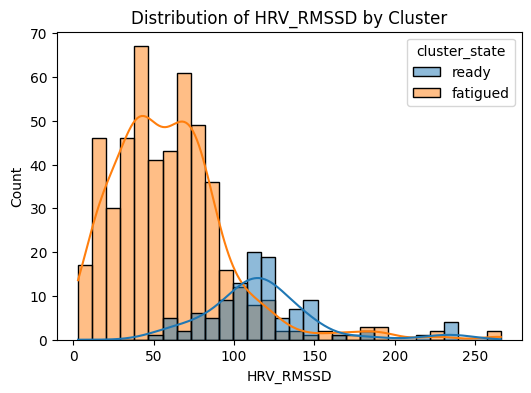

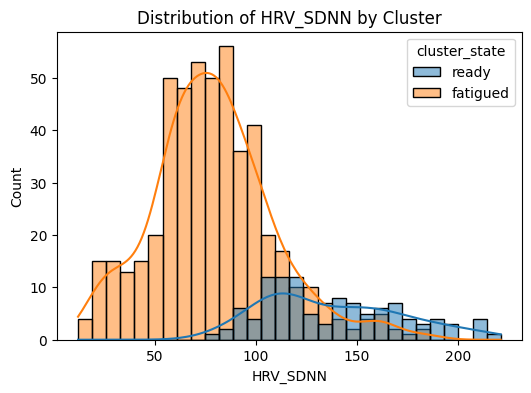

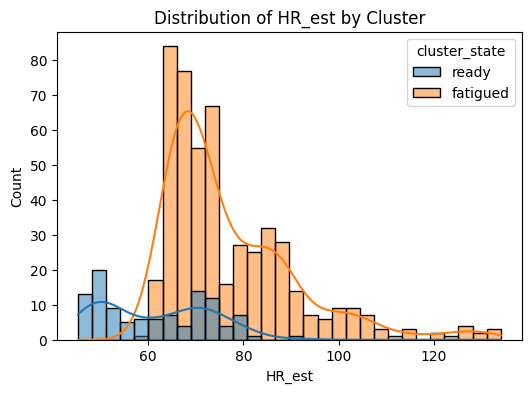

In [67]:

import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["HRV_RMSSD", "HRV_SDNN", "HR_est"]

for m in metrics:
    plt.figure(figsize=(6,4))
    sns.histplot(data=clean_df, x=m, hue="cluster_state", kde=True, bins=30)
    plt.title(f"Distribution of {m} by Cluster")
    plt.show()


In [68]:
rmssd_sorted = clean_df["HRV_RMSSD"].sort_values()
baseline_rmssd = rmssd_sorted[int(0.80 * len(rmssd_sorted))]  # 80th percentile
baseline_rmssd


np.float64(122.33129221480925)

In [69]:
clean_df["true_label"] = clean_df["HRV_RMSSD"].apply(
    lambda r: "ready" if r >= baseline_rmssd else "fatigued"
)


In [70]:
from sklearn.metrics import accuracy_score

acc_physio = accuracy_score(clean_df["true_label"], clean_df["cluster_state"])
print("GMM accuracy vs Physiological Label:", acc_physio)


GMM accuracy vs Physiological Label: 0.8489326765188834


In [71]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

results = []

for n in range(2, 10):
    pca = PCA(n_components=n, random_state=42)
    X_pca = pca.fit_transform(X.values)

    gmm = GaussianMixture(n_components=2, random_state=42)
    preds = gmm.fit_predict(X_pca)

    sil = silhouette_score(X_pca, preds)
    results.append((n, sil))

results


c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMe

[(2, np.float64(0.28027058874870747)),
 (3, np.float64(0.3311088026000273)),
 (4, np.float64(0.33182527477714113)),
 (5, np.float64(0.2751002159630111)),
 (6, np.float64(0.29569776389031144)),
 (7, np.float64(0.320626282660523)),
 (8, np.float64(0.3841303268667231)),
 (9, np.float64(0.3705125130222611))]

In [72]:
best_n = max(results, key=lambda x: x[1])[0]
best_n


8

In [73]:
pca = PCA(n_components=best_n, random_state=42)
X_pca = pca.fit_transform(X.values)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_pca)
clean_df["cluster"] = gmm.predict(X_pca)
clean_df["cluster_state"] = clean_df["cluster"].apply(lambda c: "ready" if 
                                                      clean_df.groupby("cluster")["HRV_RMSSD"].mean().idxmax() == c 
                                                      else "fatigued")


c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


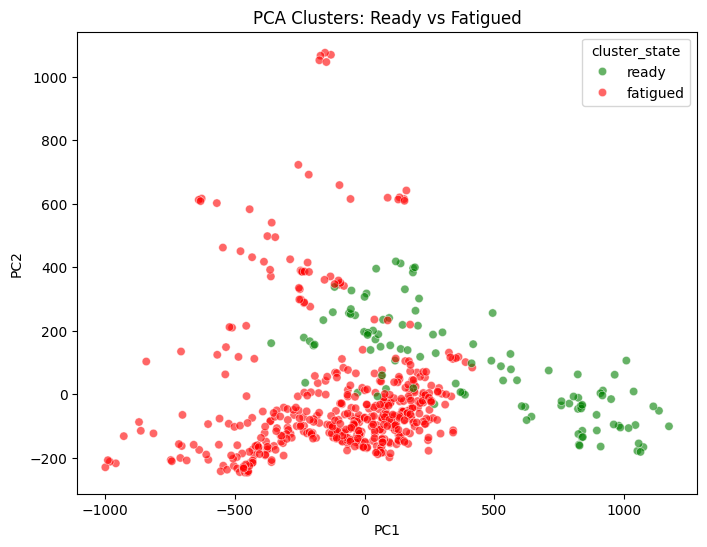

In [74]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=clean_df["cluster_state"],
    palette={"ready":"green", "fatigued":"red"},
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Clusters: Ready vs Fatigued")
plt.show()


In [ ]:
plt.figure(figsize=(14,4))
plt.plot(clean_df["center_time_sec"], clean_df["readiness_score"], color="blue")
plt.xlabel("Time (sec)")
plt.ylabel("Readiness Score (0â€“100)")
plt.title("Readiness Over Time")
plt.grid(True)
plt.show()


In [76]:
def load_subject(subject):
    folder = os.path.join(base_dir, subject)
    pkl_path = os.path.join(folder, f"{subject}.pkl")
    act_path = os.path.join(folder, f"{subject}_activity.csv")

    # Load PKL
    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    # ECG
    ecg = data["signal"]["chest"]["ECG"].flatten()

    # Activity CSV
    df = pd.read_csv(act_path)
    df.columns = ["raw", "time_sec"]
    df["activity"] = df["raw"].str.replace("#","",regex=False).str.strip()

    return ecg, df, subject


In [77]:
import neurokit2 as nk

fs_ecg = 700
WINDOW_SEC = 90
STEP_SEC = 15
W = WINDOW_SEC * fs_ecg
S = STEP_SEC * fs_ecg

def get_state(activity):
    READY = {"NO_ACTIVITY","BASELINE","CLEAN_BASELINE","DRIVING","LUNCH","WORKING"}
    FATIGUE = {"STAIRS","SOCCER","CYCLING","WALKING"}
    if activity in READY: return "ready"
    if activity in FATIGUE: return "fatigued"
    return "unknown"

def activity_at_time(t, df):
    row = df[df["time_sec"] <= t]
    return row.iloc[-1]["activity"] if len(row)>0 else "unknown"

def compute_hrv_window(ecg_seg, fs):
    ecg_clean = nk.ecg_clean(ecg_seg, sampling_rate=fs)
    _, r = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rlocs = r["ECG_R_Peaks"]

    duration = len(ecg_seg)/fs
    if len(rlocs)<3 or duration<30:
        return None

    hrv_time = nk.hrv_time(r, sampling_rate=fs, show=False)
    hrv_freq = nk.hrv_frequency(r, sampling_rate=fs, show=False)

    hr = len(rlocs) * 60 / duration
    SQI = 1.0 if 35 < hr < 200 else 0.0

    out = {**hrv_time.iloc[0].to_dict(), **hrv_freq.iloc[0].to_dict()}
    out["HR_est"] = hr
    out["n_beats"] = len(rlocs)
    out["window_duration_sec"] = duration
    out["SQI"] = SQI
    return out


In [79]:
import os

all_features = []

for subject in subjects:
    print("Processing", subject)
    ecg, act_df, sid = load_subject(subject)

    start = 0
    while start + W <= len(ecg):
        end = start + W
        center = (start + end)//2
        t = center / fs_ecg

        a = activity_at_time(t, act_df)
        s = get_state(a)
        if s=="unknown":
            start += S
            continue

        hrv = compute_hrv_window(ecg[start:end], fs_ecg)
        if hrv is None:
            start += S
            continue

        hrv["activity"] = a
        hrv["state"] = s
        hrv["center_time"] = t
        hrv["subject"] = sid

        all_features.append(hrv)
        start += S


Processing S1
Processing S10
Processing S11
Processing S12
Processing S13
Processing S14
Processing S15
Processing S2
Processing S3
Processing S4
Processing S5


In [80]:
full_df = pd.DataFrame(all_features)
print("Total HRV windows:", len(full_df))
full_df.head()


Total HRV windows: 6492


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_HFn,HRV_LnHF,HR_est,n_beats,window_duration_sec,SQI,activity,state,center_time,subject
0,1018.193760,164.447481,NaN,NaN,NaN,NaN,NaN,NaN,140.944169,141.711230,...,0.226264,-4.735823,58.666667,88,90.0,1.0,NO_ACTIVITY,ready,45.0,S1
1,1049.058824,167.226933,NaN,NaN,NaN,NaN,NaN,NaN,114.533426,115.120978,...,0.360957,-4.549986,57.333333,86,90.0,1.0,NO_ACTIVITY,ready,60.0,S1
2,1113.688969,176.308980,NaN,NaN,NaN,NaN,NaN,NaN,141.577603,142.332412,...,0.325543,-5.422623,53.333333,80,90.0,1.0,NO_ACTIVITY,ready,75.0,S1
3,1167.312030,197.108067,NaN,NaN,NaN,NaN,NaN,NaN,144.628447,145.469770,...,0.648480,-4.782728,51.333333,77,90.0,1.0,BASELINE,ready,90.0,S1
4,1217.064579,211.552394,NaN,NaN,NaN,NaN,NaN,NaN,145.205890,146.133997,...,0.738313,-4.513836,49.333333,74,90.0,1.0,BASELINE,ready,105.0,S1


In [81]:
numeric_cols = [c for c in full_df.columns 
                if full_df[c].dtype!='object' and c not in ["center_time"]]

numeric_cols = [c for c in numeric_cols if full_df[c].notna().sum()>0]

X = full_df[numeric_cols].replace([np.inf,-np.inf], np.nan).dropna()
full_df = full_df.loc[X.index].reset_index(drop=True)

print("X:", X.shape)


X: (6492, 31)


In [83]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X)

gmm = GaussianMixture(n_components=8, random_state=42)
gmm.fit(X_pca)

full_df["cluster"] = gmm.predict(X_pca)


In [84]:
means = full_df.groupby("cluster")["HRV_RMSSD"].mean()
ready_cluster = means.idxmax()

full_df["cluster_state"] = full_df["cluster"].apply(
    lambda c: "ready" if c==ready_cluster else "fatigued")


In [98]:
import pickle
from pathlib import Path

model_dir = Path("models")
model_dir.mkdir(parents=True, exist_ok=True)

model_bundle = {
    "pca": pca,
    "gmm": gmm,
    "numeric_cols": numeric_cols,
    "ready_cluster": ready_cluster,
}

model_path = model_dir / "readiness_model.pkl"
with model_path.open("wb") as f:
    pickle.dump(model_bundle, f)

print(f"Saved readiness model (PCA+GMM) to {model_path.resolve()}")


NameError: name 'net' is not defined

In [85]:
def readiness(row):
    x = row[numeric_cols].values.reshape(1,-1)
    return 100*gmm.predict_proba(pca.transform(x))[0][ready_cluster]

full_df["readiness"] = full_df.apply(readiness, axis=1)


c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\kmdee\anaconda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\kmdee\anaconda\envs\tf-gpu

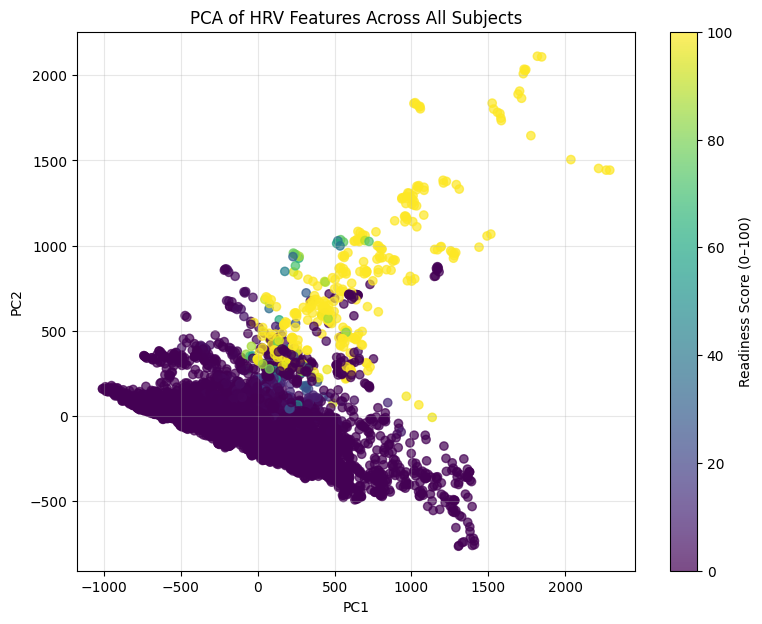

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,7))
sc = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=full_df["readiness"],
    cmap="viridis",
    alpha=0.7,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of HRV Features Across All Subjects")
cbar = plt.colorbar(sc)
cbar.set_label("Readiness Score (0â€“100)")
plt.grid(True, alpha=0.3)
plt.show()


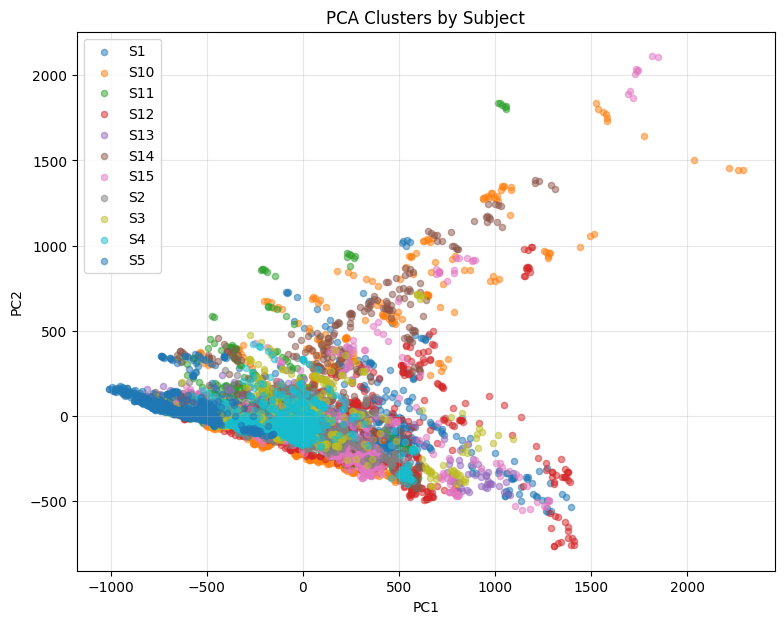

In [87]:
subjects = full_df["subject"].unique()
plt.figure(figsize=(9,7))
for s in subjects:
    mask = full_df["subject"] == s
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        alpha=0.5,
        label=s,
        s=20
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Clusters by Subject")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


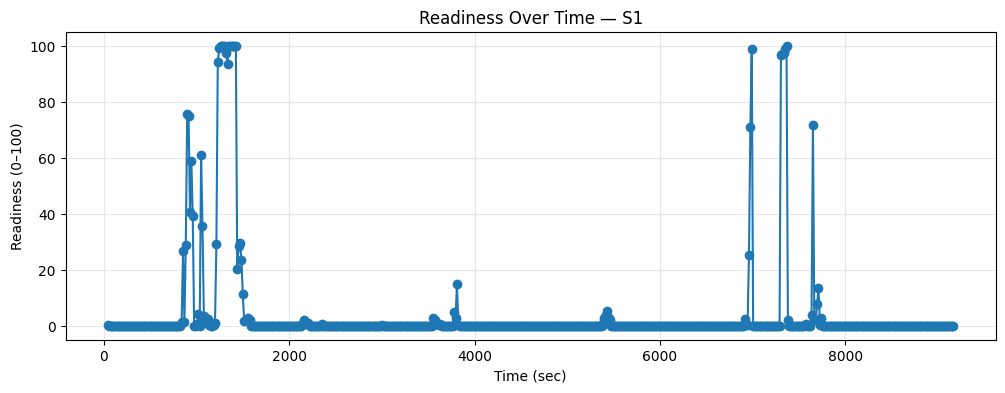

In [88]:
def plot_subject_readiness(df, subject_id):
    sub = df[df["subject"] == subject_id].sort_values("center_time")
    plt.figure(figsize=(12,4))
    plt.plot(sub["center_time"], sub["readiness"], marker="o", linestyle="-")
    plt.title(f"Readiness Over Time â€” {subject_id}")
    plt.xlabel("Time (sec)")
    plt.ylabel("Readiness (0â€“100)")
    plt.grid(True, alpha=0.3)
    plt.show()

# Example:
plot_subject_readiness(full_df, "S1")
# plot_subject_readiness(full_df, "S2")


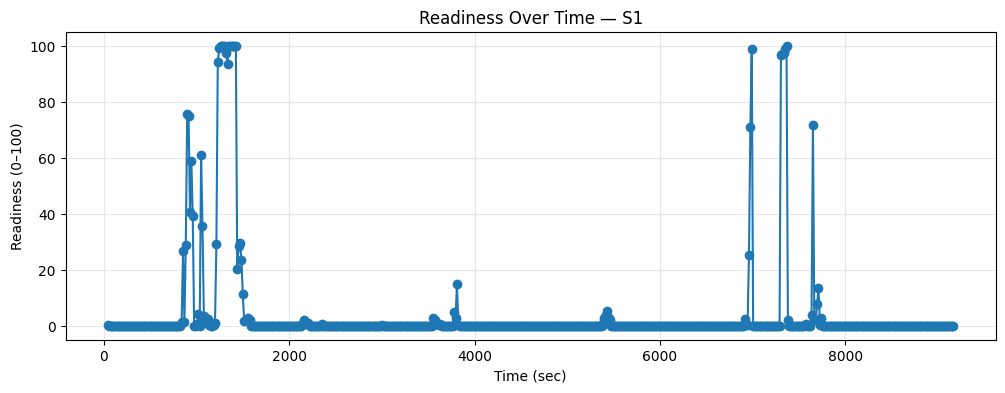

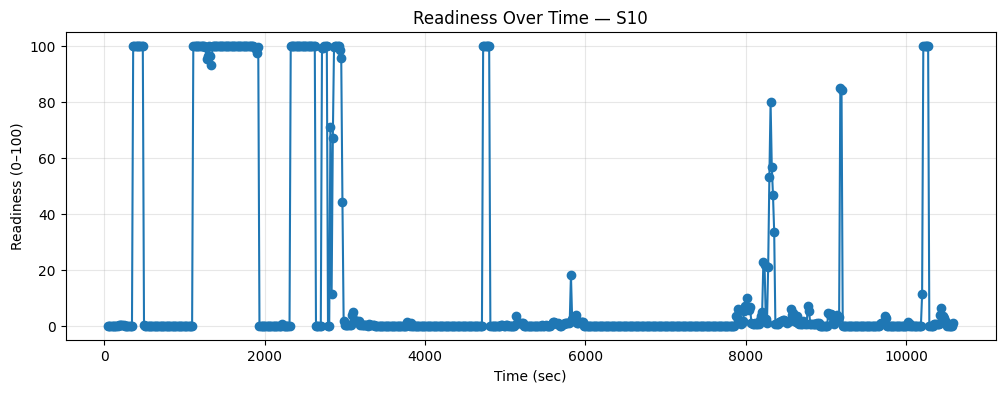

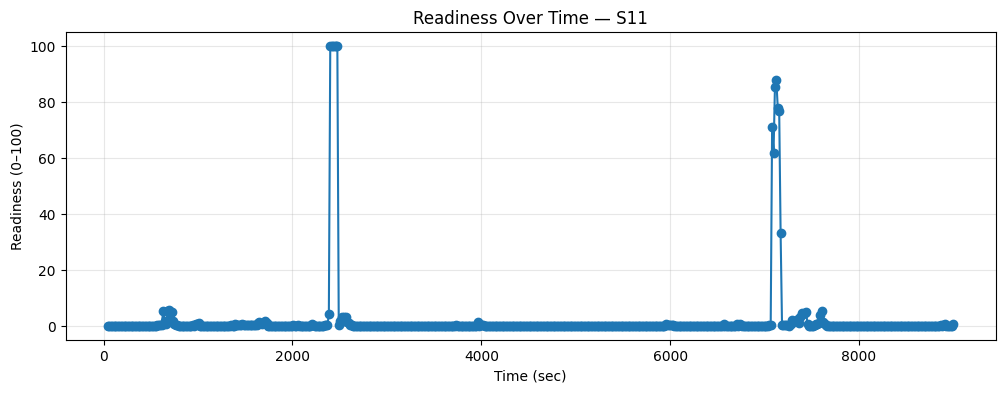

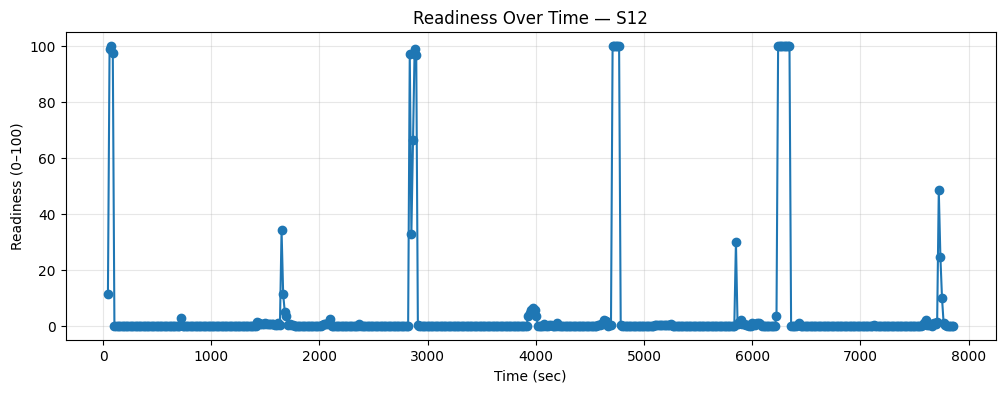

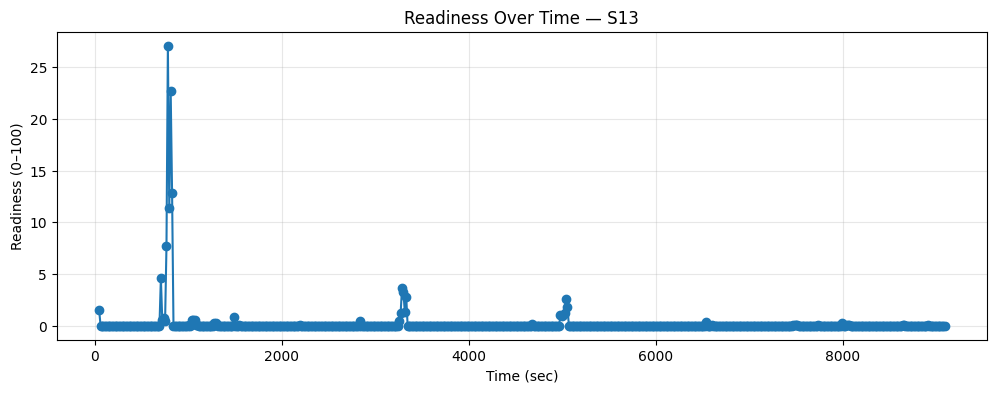

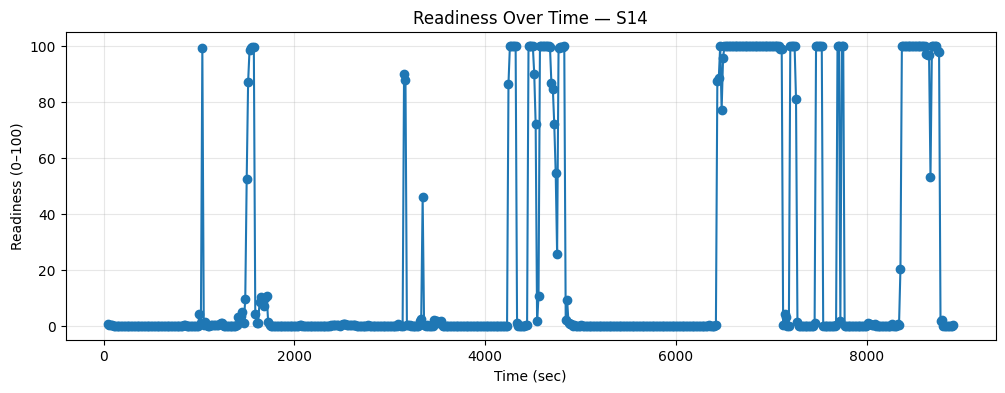

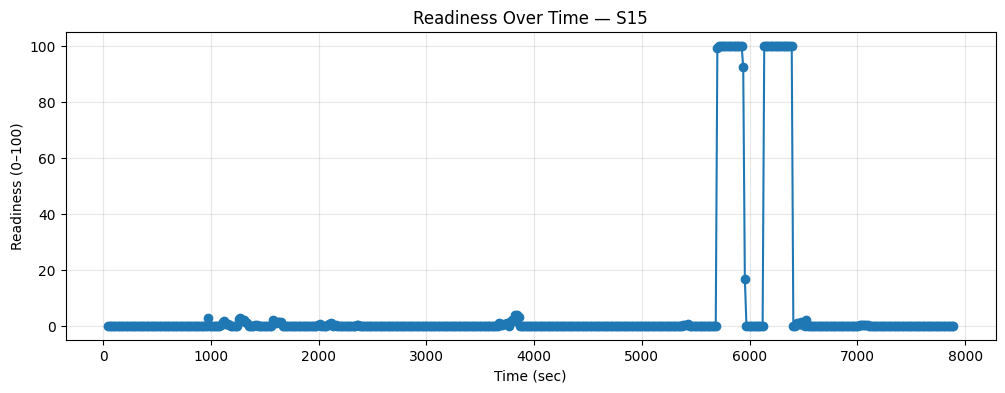

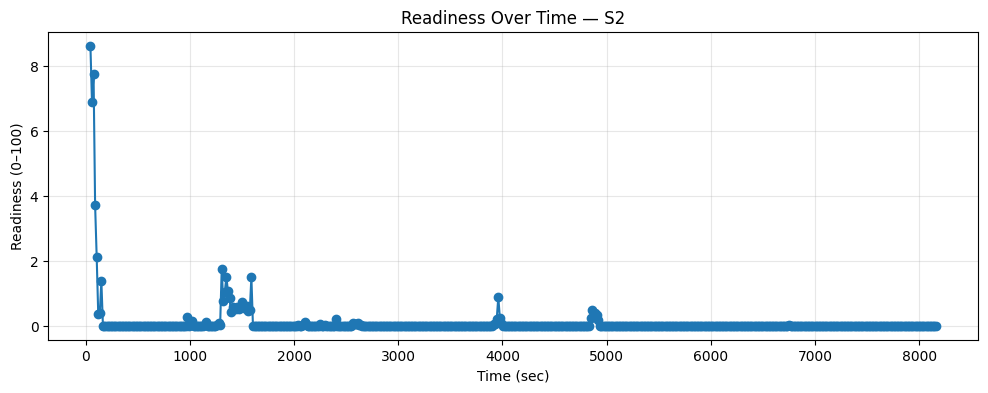

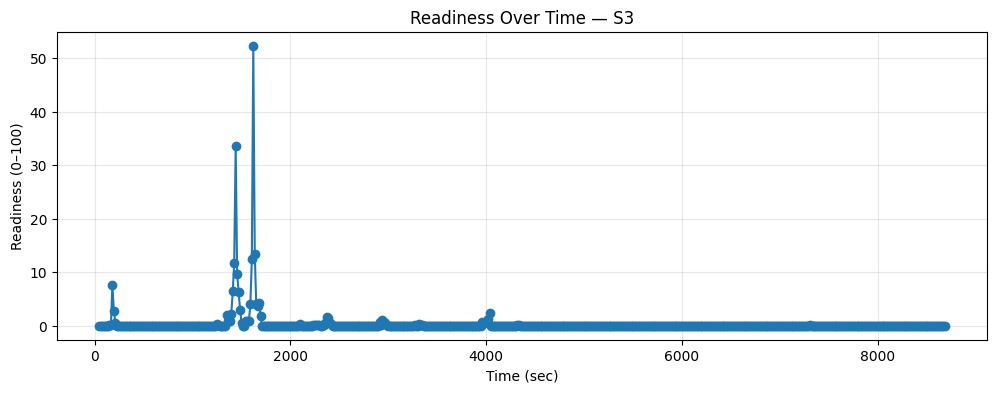

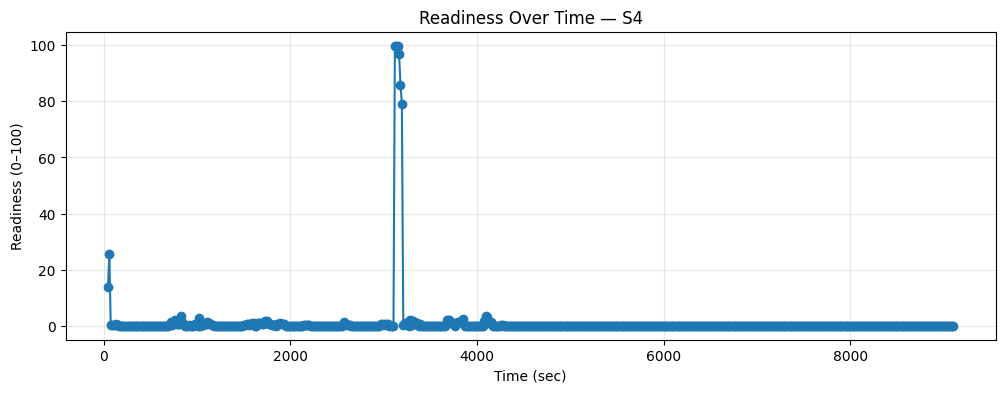

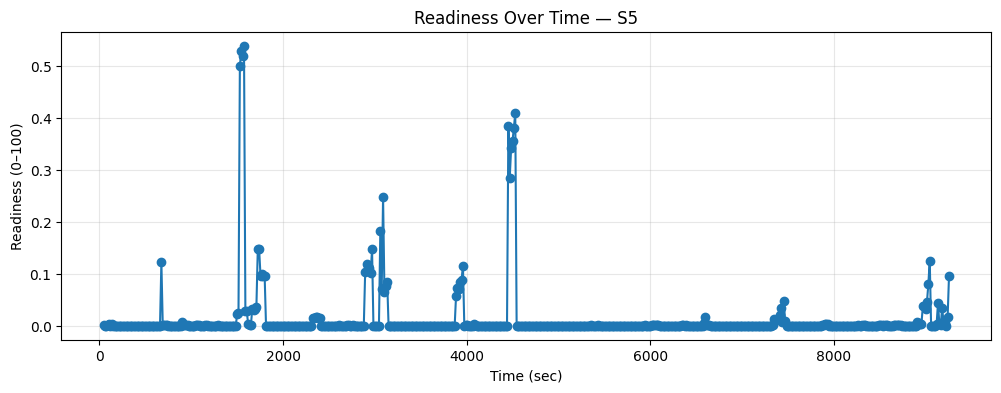

In [89]:
for sid in full_df["subject"].unique():
    plot_subject_readiness(full_df, sid)


In [90]:
summary = full_df.groupby("subject").agg(
    mean_readiness=("readiness", "mean"),
    std_readiness=("readiness", "std"),
    n_windows=("readiness", "count"),
    ready_ratio=("cluster_state", lambda x: (x=="ready").mean())
).reset_index()

print(summary)


   subject  mean_readiness  std_readiness  n_windows  ready_ratio
0       S1        4.674221      19.066747        609     0.042693
1      S10       16.720095      36.199981        704     0.163352
2      S11        2.037567      12.594066        598     0.020067
3      S12        4.310288      19.052188        522     0.040230
4      S13        0.192687       1.655499        604     0.000000
5      S14       20.918183      39.666911        592     0.211149
6      S15        6.808384      24.906446        524     0.066794
7       S2        0.095293       0.628161        542     0.000000
8       S3        0.353173       2.832032        577     0.001733
9       S4        1.138580       9.368837        605     0.009917
10      S5        0.013303       0.059315        615     0.000000


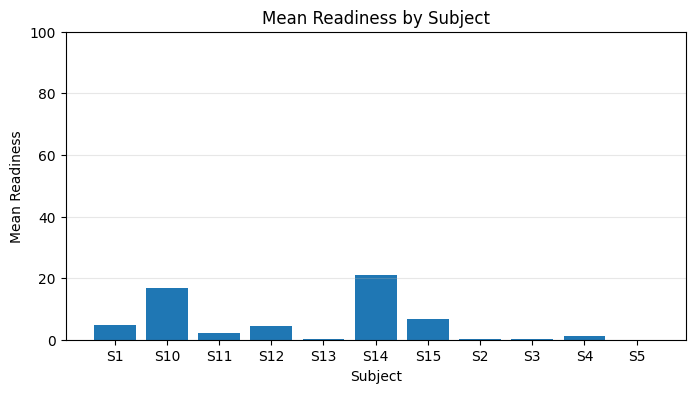

In [91]:
plt.figure(figsize=(8,4))
plt.bar(summary["subject"], summary["mean_readiness"])
plt.ylabel("Mean Readiness")
plt.xlabel("Subject")
plt.title("Mean Readiness by Subject")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3)
plt.show()


In [93]:
import pickle
from pathlib import Path

def save_readiness_model(model_path="models/readiness_model.pkl"):
    bundle = {
        "pca": pca,
        "gmm": gmm,
        "numeric_cols": numeric_cols,
        "ready_cluster": ready_cluster,
    }
    target = Path(model_path)
    target.parent.mkdir(parents=True, exist_ok=True)
    with target.open("wb") as f:
        pickle.dump(bundle, f)
    print(f"Saved readiness model to {target.resolve()}")

def load_readiness_model(model_path="models/readiness_model.pkl"):
    with open(model_path, "rb") as f:
        return pickle.load(f)


In [1]:
import pickle
import numpy as np

pkl_path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1.pkl"

with open(pkl_path, "rb") as f:
    s1 = pickle.load(f, encoding="latin1")

ecg = s1["signal"]["chest"]["ECG"].flatten()
fs_ecg = 700  # RespiBAN chest sampling rate

print("Loaded ECG. Length:", len(ecg))


Loaded ECG. Length: 6448400


In [2]:
import h5py

def load_respiBAN_signals(h5_path):
    signals = {}
    with h5py.File(h5_path, "r") as h5:
        root_key = list(h5.keys())[0]  # MAC address
        root = h5[root_key]

        print("Root key:", root_key)
        print("Subkeys:", list(root.keys()))

        def collect(group, prefix=""):
            for name, item in group.items():
                full = f"{prefix}/{name}" if prefix else name
                if isinstance(item, h5py.Dataset):
                    signals[full] = item[:]
                    print("Loaded:", full, "shape:", item.shape)
                else:
                    collect(item, full)

        collect(root)
    return signals


In [3]:
respiBAN_path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1_RespiBAN.h5"
respiban_signals = load_respiBAN_signals(respiBAN_path)


Root key: 00:07:80:D8:AB:58
Subkeys: ['digital', 'events', 'plugin', 'raw', 'support']
Loaded: digital/digital_1 shape: (6490316, 1)
Loaded: events/digital shape: (0, 4)
Loaded: events/sync shape: (0, 3)
Loaded: raw/channel_1 shape: (6490316, 1)
Loaded: raw/channel_2 shape: (6490316, 1)
Loaded: raw/channel_3 shape: (6490316, 1)
Loaded: raw/channel_4 shape: (6490316, 1)
Loaded: raw/channel_5 shape: (6490316, 1)
Loaded: raw/channel_6 shape: (6490316, 1)
Loaded: raw/channel_7 shape: (6490316, 1)
Loaded: raw/channel_8 shape: (6490316, 1)
Loaded: raw/nSeq shape: (6490316, 1)
Loaded: support/level_10/channel_1/Mx shape: (649031, 1)
Loaded: support/level_10/channel_1/mean shape: (649031, 1)
Loaded: support/level_10/channel_1/mean_x2 shape: (649031, 1)
Loaded: support/level_10/channel_1/mx shape: (649031, 1)
Loaded: support/level_10/channel_1/sd shape: (649031, 1)
Loaded: support/level_10/channel_1/t shape: (649031, 1)
Loaded: support/level_10/channel_2/Mx shape: (649031, 1)
Loaded: support/le

In [4]:
def pick_signal(signals, keyword):
    keyword = keyword.lower()
    for k, v in signals.items():
        if keyword in k.lower():
            print(f"Using {keyword.upper()} from:", k)
            return v
    return None

resp_signal = pick_signal(respiban_signals, "resp")
eda_signal  = pick_signal(respiban_signals, "eda")


In [6]:
import h5py

file_path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1_RespiBAN.h5"

def scan_h5(h5_obj, prefix=""):
    for key in h5_obj.keys():
        full_path = f"{prefix}/{key}" if prefix else key
        item = h5_obj[key]
        
        if isinstance(item, h5py.Dataset):
            print("DATASET:", full_path, "shape:", item.shape)
        elif isinstance(item, h5py.Group):
            print("GROUP:", full_path)
            scan_h5(item, full_path)

with h5py.File(file_path, "r") as h5:
    print("ROOT KEYS:", list(h5.keys()))
    scan_h5(h5)


ROOT KEYS: ['00:07:80:D8:AB:58']
GROUP: 00:07:80:D8:AB:58
GROUP: 00:07:80:D8:AB:58/digital
DATASET: 00:07:80:D8:AB:58/digital/digital_1 shape: (6490316, 1)
GROUP: 00:07:80:D8:AB:58/events
DATASET: 00:07:80:D8:AB:58/events/digital shape: (0, 4)
DATASET: 00:07:80:D8:AB:58/events/sync shape: (0, 3)
GROUP: 00:07:80:D8:AB:58/plugin
GROUP: 00:07:80:D8:AB:58/raw
DATASET: 00:07:80:D8:AB:58/raw/channel_1 shape: (6490316, 1)
DATASET: 00:07:80:D8:AB:58/raw/channel_2 shape: (6490316, 1)
DATASET: 00:07:80:D8:AB:58/raw/channel_3 shape: (6490316, 1)
DATASET: 00:07:80:D8:AB:58/raw/channel_4 shape: (6490316, 1)
DATASET: 00:07:80:D8:AB:58/raw/channel_5 shape: (6490316, 1)
DATASET: 00:07:80:D8:AB:58/raw/channel_6 shape: (6490316, 1)
DATASET: 00:07:80:D8:AB:58/raw/channel_7 shape: (6490316, 1)
DATASET: 00:07:80:D8:AB:58/raw/channel_8 shape: (6490316, 1)
DATASET: 00:07:80:D8:AB:58/raw/nSeq shape: (6490316, 1)
GROUP: 00:07:80:D8:AB:58/support
GROUP: 00:07:80:D8:AB:58/support/level_10
GROUP: 00:07:80:D8:AB:5

In [7]:
import h5py
import numpy as np

path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1_RespiBAN.h5"

channels = {}
with h5py.File(path, "r") as h5:
    root = list(h5.keys())[0]
    for i in range(1, 9):
        channels[f"ch{i}"] = h5[f"{root}/raw/channel_{i}"][:].flatten()

for k, v in channels.items():
    print(k, "len =", len(v), "min =", np.min(v), "max =", np.max(v))


ch1 len = 6490316 min = 2 max = 65535
ch2 len = 6490316 min = 0 max = 0
ch3 len = 6490316 min = 0 max = 0
ch4 len = 6490316 min = 0 max = 0
ch5 len = 6490316 min = 29522 max = 52756
ch6 len = 6490316 min = 25585 max = 39221
ch7 len = 6490316 min = 11755 max = 47789
ch8 len = 6490316 min = 19583 max = 50228


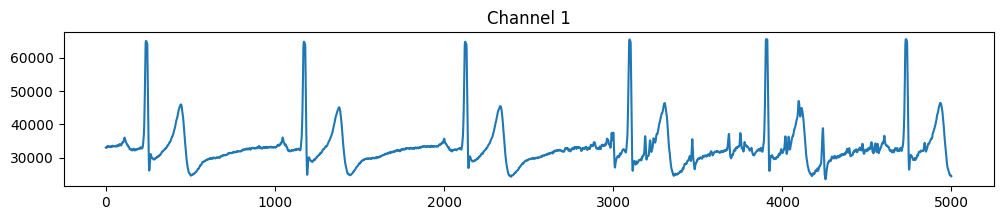

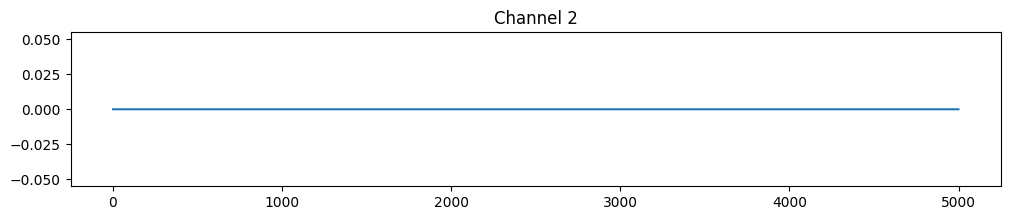

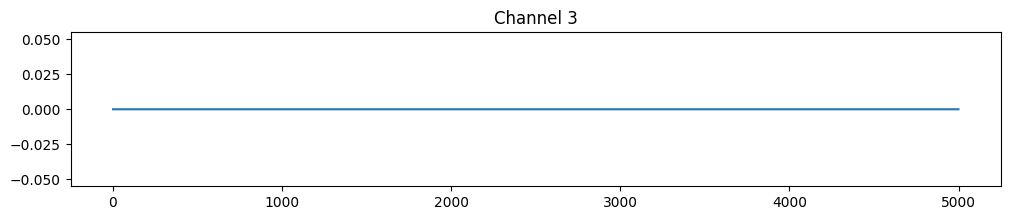

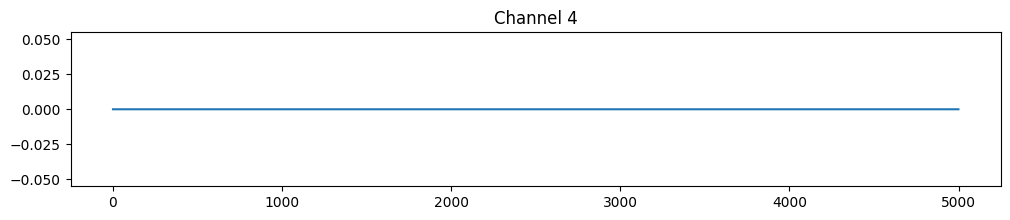

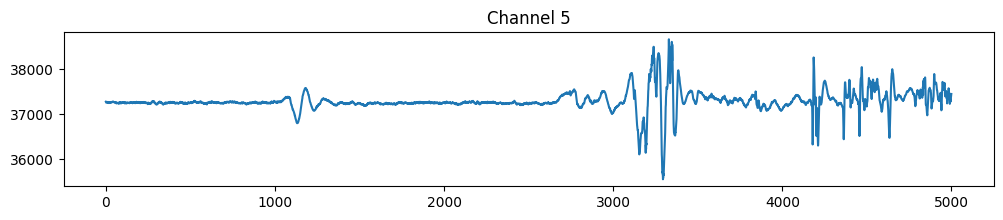

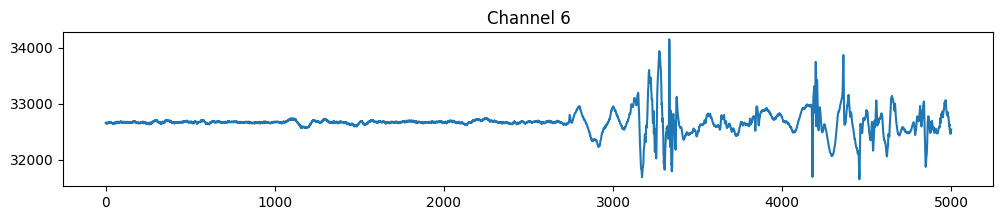

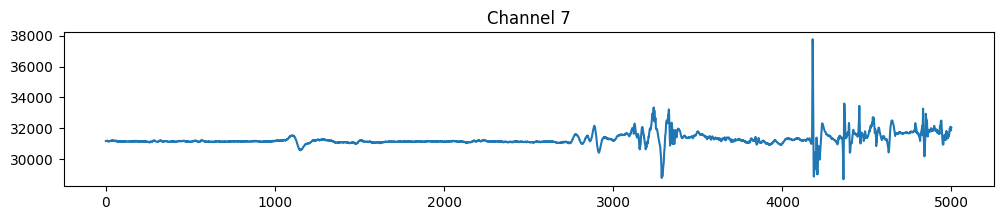

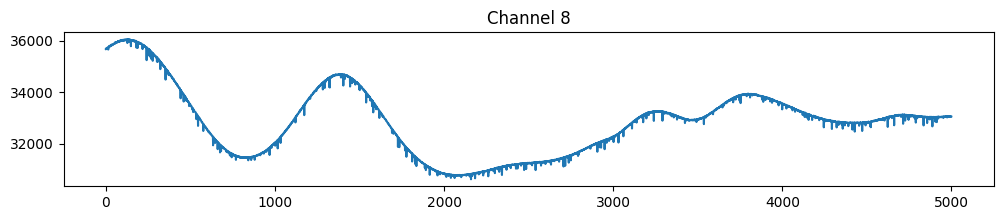

In [8]:
import matplotlib.pyplot as plt

for i in range(1, 9):
    sig = channels[f"ch{i}"][:5000]  # first 5,000 samples
    plt.figure(figsize=(12,2))
    plt.plot(sig)
    plt.title(f"Channel {i}")
    plt.show()


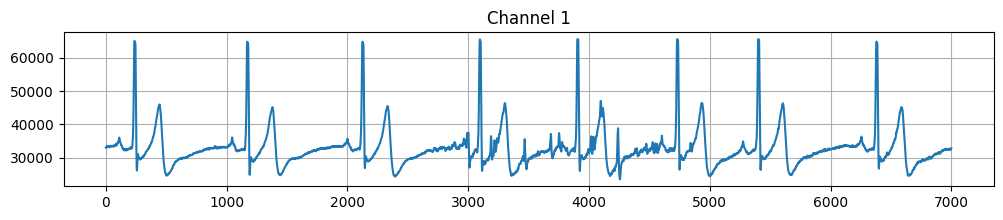

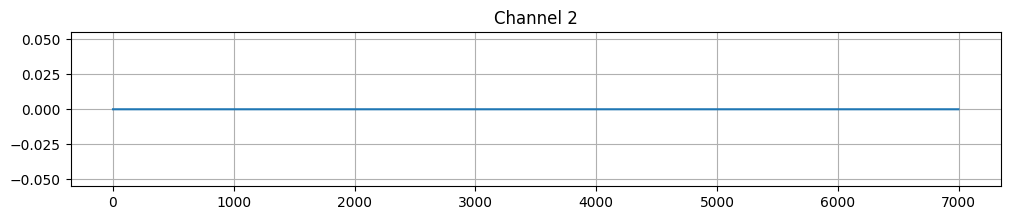

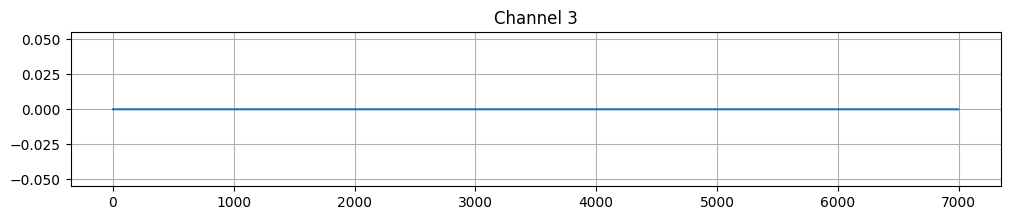

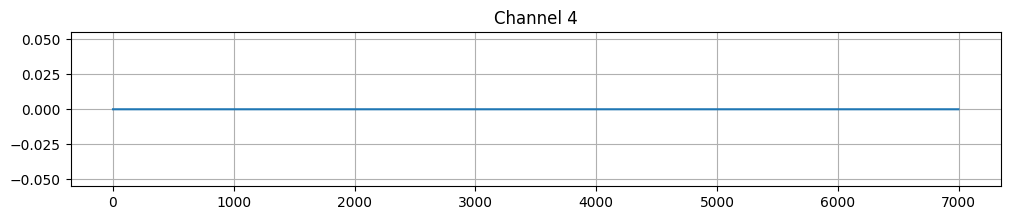

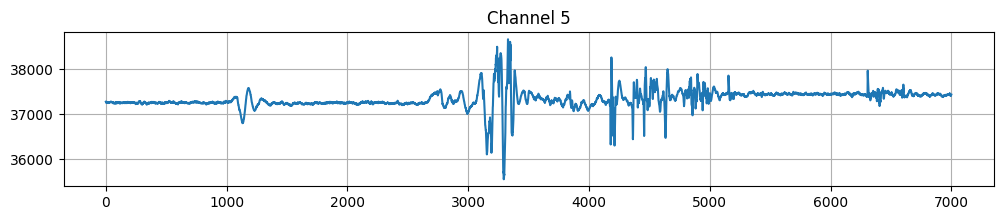

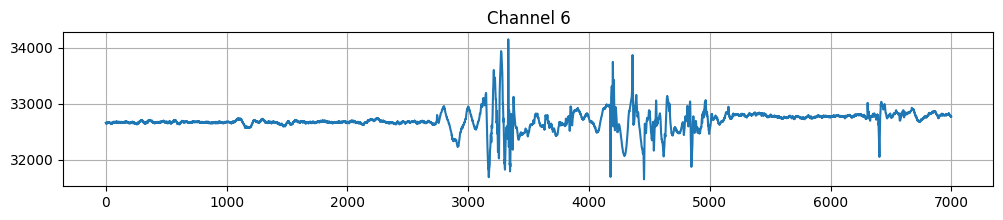

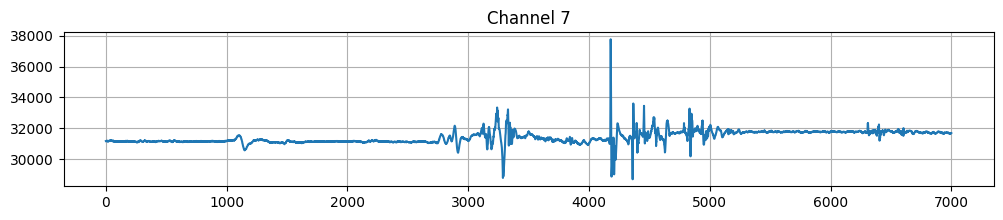

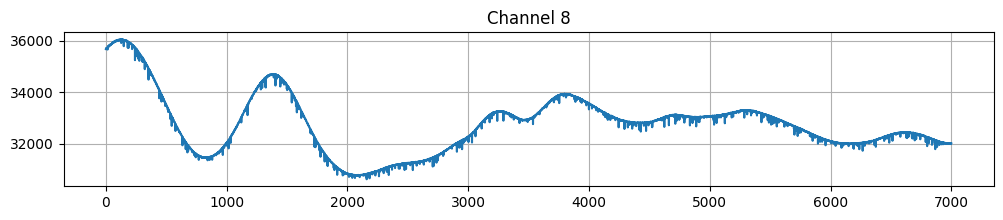

In [11]:
import matplotlib.pyplot as plt

for i in range(1, 9):
    sig = channels[f"ch{i}"][:7000]  # view first 10 seconds
    plt.figure(figsize=(12, 2))
    plt.plot(sig)
    plt.title(f"Channel {i}")
    plt.grid(True)
    plt.show()


In [12]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

respi_path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1_RespiBAN.h5"

def load_respi_ban(path):
    with h5py.File(path, "r") as f:
        root = list(f.keys())[0]
        raw = f[f"{root}/raw"]

        # Extract 8 channels
        ch1 = np.array(raw["channel_1"])[:, 0]  # ECG-like
        ch2 = np.array(raw["channel_2"])[:, 0]
        ch3 = np.array(raw["channel_3"])[:, 0]
        ch4 = np.array(raw["channel_4"])[:, 0]
        ch5 = np.array(raw["channel_5"])[:, 0]  # EMG/Motion
        ch6 = np.array(raw["channel_6"])[:, 0]  # EMG/Motion
        ch7 = np.array(raw["channel_7"])[:, 0]  # EDA-like
        ch8 = np.array(raw["channel_8"])[:, 0]  # Respiration

    return {
        "ecg": ch1,
        "motion_1": ch5,
        "motion_2": ch6,
        "motion_3": ch7,
        "respiration": ch8
    }

respi_data = load_respi_ban(respi_path)
print({k: len(v) for k, v in respi_data.items()})


{'ecg': 6490316, 'motion_1': 6490316, 'motion_2': 6490316, 'motion_3': 6490316, 'respiration': 6490316}


In [13]:
from scipy.signal import find_peaks

def extract_resp_features(resp_signal, fs=700):  
    # RespiBAN sampling = 700 Hz (based on length & known spec)
    # Apply low-pass filter for respiration
    b, a = butter(2, 0.5/(fs/2), btype='low')
    resp_filt = filtfilt(b, a, resp_signal)

    # Detect respiration peaks
    peaks, _ = find_peaks(resp_filt, distance=fs*1.0)  # at least 1s between breaths

    # Breathing rate (BPM)
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs
        resp_rate_bpm = 60 / np.mean(rr_intervals)
    else:
        resp_rate_bpm = np.nan

    # Amplitude variability
    resp_amp = np.std(resp_filt)

    return resp_rate_bpm, resp_amp, resp_filt


In [14]:
def extract_motion_features(sig):
    var = np.var(sig)
    abs_mean = np.mean(np.abs(sig - np.mean(sig)))
    spikes = np.sum(np.abs(np.diff(sig)) > (np.std(sig)*5))

    return var, abs_mean, spikes


In [15]:
m1 = extract_motion_features(respi_data["motion_1"])
m2 = extract_motion_features(respi_data["motion_2"])
m3 = extract_motion_features(respi_data["motion_3"])

motion_features = {
    "motion_var": np.mean([m1[0], m2[0], m3[0]]),
    "motion_abs": np.mean([m1[1], m2[1], m3[1]]),
    "motion_spikes": np.mean([m1[2], m2[2], m3[2]])
}

motion_features


{'motion_var': np.float64(779169.7108764603),
 'motion_abs': np.float64(618.1075593613563),
 'motion_spikes': np.float64(3129310.6666666665)}

In [27]:
def add_respi_motion_to_windows(features_df, respi_data, fs=700):
    resp = respi_data["respiration"]
    mot = (respi_data["motion_1"] + respi_data["motion_2"] + respi_data["motion_3"]) / 3

    resp_rate_list = []
    resp_amp_list = []
    motion_var_list = []
    motion_spikes_list = []

    for _, row in features_df.iterrows():
        start = int(row["start_time_sec"] * fs)
        end = int(row["end_time_sec"] * fs)

        resp_seg = resp[start:end]
        mot_seg = mot[start:end]

        # resp
        r_rate, r_amp, _ = extract_resp_features(resp_seg, fs)
        resp_rate_list.append(r_rate)
        resp_amp_list.append(r_amp)

        # motion
        mv, ma, ms = extract_motion_features(mot_seg)
        motion_var_list.append(mv)
        motion_spikes_list.append(ms)

    features_df["resp_rate"] = resp_rate_list
    features_df["resp_amp"] = resp_amp_list
    features_df["motion_var"] = motion_var_list
    features_df["motion_spikes"] = motion_spikes_list

    return features_df


In [26]:
with h5py.File(file_path, "r") as h5:
    grp = list(h5.keys())[0]

    sync_path = f"{grp}/events/sync"
    digital_path = f"{grp}/digital/digital_1"

    print("Sync dataset shape:", h5[sync_path].shape)
    print("Digital dataset shape:", h5[digital_path].shape)

    # Try to read sync timestamps
    try:
        sync_events = h5[sync_path][:]
        print("First 10 sync events:", sync_events[:10])
    except:
        print("Could not read sync events")


Sync dataset shape: (0, 3)
Digital dataset shape: (6490316, 1)
First 10 sync events: []


In [28]:
# Example: if sync events include timestamps for both devices
ecg_start_time = features_df['start_time_sec'].min()  # ECG timeline
respi_start_time = sync_events[0, 0]                  # RespiBAN timeline

offset_sec = ecg_start_time - respi_start_time
print("Computed offset (sec):", offset_sec)


NameError: name 'features_df' is not defined

In [29]:
print(features_df.head())


NameError: name 'features_df' is not defined

In [30]:
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk

pkl_path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1.pkl"

with open(pkl_path, "rb") as f:
    s1 = pickle.load(f, encoding="latin1")

ecg = s1["signal"]["chest"]["ECG"].flatten()
fs = 700  # sampling rate
print("ECG length:", len(ecg))


ECG length: 6448400


In [31]:
activity_path = r"G:\exait ai\data\ppg+dalia\data\PPG_FieldStudy\S1\S1_activity.csv"
act = pd.read_csv(activity_path)


In [32]:
def get_activity_at_time(t_sec, df):
    for _, row in df.iterrows():
        if row["start_idx"] <= t_sec <= row["end_idx"]:
            return row["activity"]
    return "UNKNOWN"


In [33]:
def compute_hrv(ecg_seg, fs):
    try:
        clean = nk.ecg_clean(ecg_seg, sampling_rate=fs)
        _, rpeaks = nk.ecg_peaks(clean, sampling_rate=fs)
        if len(rpeaks["ECG_R_Peaks"]) < 3:
            return None
        hrv_time = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)
        hrv_freq = nk.hrv_frequency(rpeaks, sampling_rate=fs, show=False)
        hr = len(rpeaks["ECG_R_Peaks"]) * 60 / (len(ecg_seg)/fs)
        feat = {**hrv_time.iloc[0].to_dict(),
                **hrv_freq.iloc[0].to_dict(),
                "HR_est": hr}
        return feat
    except:
        return None


In [35]:
print(act.columns)
print(act.head())


Index(['# SUBJECT_ID', ' S1'], dtype='object')
    # SUBJECT_ID    S1
0  # NO_ACTIVITY     0
1     # BASELINE    90
2  # NO_ACTIVITY   791
3       # STAIRS   837
4  # NO_ACTIVITY  1125


In [36]:
act = act.rename(columns=lambda x: x.strip().replace("# ", "").replace(" ", ""))

print(act.columns)
print(act.head())


Index(['SUBJECT_ID', 'S1'], dtype='object')
      SUBJECT_ID    S1
0  # NO_ACTIVITY     0
1     # BASELINE    90
2  # NO_ACTIVITY   791
3       # STAIRS   837
4  # NO_ACTIVITY  1125


In [37]:
def convert_change_points(df):
    rows = []
    for i in range(len(df)-1):
        label = df.iloc[i]["SUBJECT_ID"].replace("#","").strip()
        start = int(df.iloc[i]["S1"])
        end = int(df.iloc[i+1]["S1"])
        rows.append([label, start, end])

    # last interval (until end of signal)
    rows.append([
        df.iloc[-1]["SUBJECT_ID"].replace("#","").strip(),
        int(df.iloc[-1]["S1"]),
        None  # unknown end yet
    ])

    return pd.DataFrame(rows, columns=["activity", "start_idx", "end_idx"])

activity_df = convert_change_points(act)
print(activity_df.head(10))


      activity  start_idx  end_idx
0  NO_ACTIVITY          0     90.0
1     BASELINE         90    791.0
2  NO_ACTIVITY        791    837.0
3       STAIRS        837   1125.0
4  NO_ACTIVITY       1125   1210.0
5       SOCCER       1210   1556.0
6  NO_ACTIVITY       1556   1918.0
7      CYCLING       1918   2331.0
8  NO_ACTIVITY       2331   2935.0
9      DRIVING       2935   3825.0


In [38]:
activity_df.loc[activity_df.index[-1], "end_idx"] = len(ecg) / fs


In [39]:
def get_activity_at_time(t_sec, df):
    for _, row in df.iterrows():
        if row["start_idx"] <= t_sec < row["end_idx"]:
            return row["activity"]
    return "UNKNOWN"


In [40]:
print(activity_df.head(10))


      activity  start_idx  end_idx
0  NO_ACTIVITY          0     90.0
1     BASELINE         90    791.0
2  NO_ACTIVITY        791    837.0
3       STAIRS        837   1125.0
4  NO_ACTIVITY       1125   1210.0
5       SOCCER       1210   1556.0
6  NO_ACTIVITY       1556   1918.0
7      CYCLING       1918   2331.0
8  NO_ACTIVITY       2331   2935.0
9      DRIVING       2935   3825.0


In [41]:
center_t = (pos + W/2) / fs


In [42]:
activity_df["start_time_sec"] = activity_df["start_idx"] / fs
activity_df["end_time_sec"] = activity_df["end_idx"] / fs


In [43]:
def get_activity_at_time(t_sec, df):
    row = df[(df.start_time_sec <= t_sec) & (t_sec < df.end_time_sec)]
    if len(row) > 0:
        return row.iloc[0]["activity"]
    return "UNKNOWN"


In [44]:
hrv_windows = []

W = 90 * fs
step = 15 * fs  # 15 sec hop

for pos in range(0, len(ecg)-W, step):

    ecg_seg = ecg[pos:pos+W]
    center_t = (pos + W/2) / fs
    
    activity = get_activity_at_time(center_t, activity_df)

    hrv = compute_hrv(ecg_seg, fs)
    if hrv is None:
        continue

    hrv["activity"] = activity
    hrv["start_time_sec"] = pos / fs
    hrv["end_time_sec"] = (pos + W) / fs

    hrv_windows.append(hrv)


In [45]:
features_df = pd.DataFrame(hrv_windows)
print("HRV rows:", len(features_df))
print(features_df.head())


HRV rows: 609
    HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1018.193760  164.447481         NaN         NaN         NaN         NaN   
1  1049.058824  167.226933         NaN         NaN         NaN         NaN   
2  1113.688969  176.308980         NaN         NaN         NaN         NaN   
3  1167.312030  197.108067         NaN         NaN         NaN         NaN   
4  1217.064579  211.552394         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...   HRV_VHF    HRV_TP  \
0         NaN         NaN  140.944169  141.711230  ...  0.000541  0.038783   
1         NaN         NaN  114.533426  115.120978  ...  0.000481  0.029276   
2         NaN         NaN  141.577603  142.332412  ...  0.000336  0.013564   
3         NaN         NaN  144.628447  145.469770  ...  0.000180  0.012912   
4         NaN         NaN  145.205890  146.133997  ...  0.000141  0.014840   

   HRV_LFHF   HRV_LFn   HRV_HFn  HRV_LnHF     HR

In [46]:
fs = 700  # exact RespiBAN/ECG sampling rate

activity_df["start_time_sec"] = activity_df["start_idx"] / fs
activity_df["end_time_sec"] = activity_df["end_idx"] / fs


In [47]:
print(activity_df.head(10)[["activity","start_time_sec","end_time_sec"]])


      activity  start_time_sec  end_time_sec
0  NO_ACTIVITY        0.000000      0.128571
1     BASELINE        0.128571      1.130000
2  NO_ACTIVITY        1.130000      1.195714
3       STAIRS        1.195714      1.607143
4  NO_ACTIVITY        1.607143      1.728571
5       SOCCER        1.728571      2.222857
6  NO_ACTIVITY        2.222857      2.740000
7      CYCLING        2.740000      3.330000
8  NO_ACTIVITY        3.330000      4.192857
9      DRIVING        4.192857      5.464286


In [48]:
print(center_t)
print(activity_df.head())


9165.0
      activity  start_idx  end_idx  start_time_sec  end_time_sec
0  NO_ACTIVITY          0     90.0        0.000000      0.128571
1     BASELINE         90    791.0        0.128571      1.130000
2  NO_ACTIVITY        791    837.0        1.130000      1.195714
3       STAIRS        837   1125.0        1.195714      1.607143
4  NO_ACTIVITY       1125   1210.0        1.607143      1.728571


In [49]:
activity_df["activity"] = (
    activity_df["activity"]
    .astype(str)
    .str.replace("#","")
    .str.strip()
)


In [50]:
hrv_windows = []

for pos in range(0, len(ecg)-W, step):
    ecg_seg = ecg[pos:pos+W]
    center_t = (pos + W/2) / fs
    
    activity = get_activity_at_time(center_t, activity_df)

    hrv = compute_hrv(ecg_seg, fs)
    if hrv is None:
        continue

    hrv["activity"] = activity
    hrv_windows.append(hrv)


In [52]:
hrv_windows = []

W = 90 * fs       # 90 sec window
step = 15 * fs    # 15 sec hop

for pos in range(0, len(ecg) - W, step):

    ecg_seg = ecg[pos:pos+W]
    center_t = (pos + W/2) / fs

    # Get activity
    activity = get_activity_at_time(center_t, activity_df)

    # Compute HRV
    hrv = compute_hrv(ecg_seg, fs)
    if hrv is None:
        continue

    # Add time + label
    hrv["activity"] = activity
    hrv["start_time_sec"] = pos / fs
    hrv["end_time_sec"] = (pos + W) / fs

    # Store dict
    hrv_windows.append(hrv)


In [53]:
features_df = pd.DataFrame(hrv_windows)


In [54]:
print(features_df.columns)


Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF',
       'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HR_est', 'activity',
       'start_time_sec', 'end_time_sec'],
      dtype='object')


In [55]:
print(features_df[["activity","start_time_sec","end_time_sec"]].head(10))


  activity  start_time_sec  end_time_sec
0  UNKNOWN             0.0          90.0
1  UNKNOWN            15.0         105.0
2  UNKNOWN            30.0         120.0
3  UNKNOWN            45.0         135.0
4  UNKNOWN            60.0         150.0
5  UNKNOWN            75.0         165.0
6  UNKNOWN            90.0         180.0
7  UNKNOWN           105.0         195.0
8  UNKNOWN           120.0         210.0
9  UNKNOWN           135.0         225.0
